<h1>Detección de transacciones fraudulentas con Machine Learning</h1>


<h3>Este notebook toma un dataset libre denominado creditcard.csv el cual contiene diferentes transacciones financieras, pero debido a confidencialidad de los datos, el dataset no provee los datos sensibles de usuarios ni background de los datos, así también, las variables que se tomarán como input, pasaron por un proceso de transformación PCA, por lo que las variables más importantes están contenidas dentro de V1, V2... hasta V28. Tomar en cuenta que el dataset incluye variables no transformadas como "Time" y Amount", donde "Time" contiene los segundos entre transacciones y la primera transacción dada en el dataset y "Amount" brinda el monto de la transacción. La variable "Class" toma los valores: 1 (Fraude) o 0 (No Fraude)</h3>

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)


# Utilities
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")




sns.set()
%matplotlib inline

In [142]:
#Para descargar el dataset:
#https://huggingface.co/datasets/eveval97/transacciones_credit_card/resolve/main/transacciones_credit_card.csv
df = pd.read_csv('transacciones_credit_card.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [144]:
# Ver el total de valores faltantes por columna
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Ver el porcentaje de valores faltantes por columna
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPorcentaje de valores faltantes por columna:")
print(missing_percentage)

# Filtrar columnas con valores faltantes
missing_cols = df.columns[df.isnull().any()]
print("\nColumnas con valores faltantes:")
print(missing_cols)


Valores faltantes por columna:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Porcentaje de valores faltantes por columna:
Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

Columnas con valores faltantes:
Index([], dtype='object')


In [145]:
def valores_unicos_ordenados(df):
    unique_counts = [(column, df[column].nunique()) for column in df.columns]
    unique_counts_sorted = sorted(unique_counts, key=lambda x: x[1],reverse=True)
    for column, unique_count in unique_counts_sorted:
        print(f'{column} - {unique_count} unique values')
valores_unicos_ordenados(df)

V1 - 275663 unique values
V2 - 275663 unique values
V3 - 275663 unique values
V4 - 275663 unique values
V5 - 275663 unique values
V6 - 275663 unique values
V7 - 275663 unique values
V8 - 275663 unique values
V9 - 275663 unique values
V10 - 275663 unique values
V11 - 275663 unique values
V12 - 275663 unique values
V13 - 275663 unique values
V14 - 275663 unique values
V15 - 275663 unique values
V16 - 275663 unique values
V17 - 275663 unique values
V18 - 275663 unique values
V19 - 275663 unique values
V20 - 275663 unique values
V21 - 275663 unique values
V22 - 275663 unique values
V23 - 275663 unique values
V24 - 275663 unique values
V25 - 275663 unique values
V26 - 275663 unique values
V27 - 275663 unique values
V28 - 275663 unique values
Time - 124592 unique values
Amount - 32767 unique values
Class - 2 unique values


Conteo de transacciones por clase:
Class
0    284315
1       492
Name: count, dtype: int64


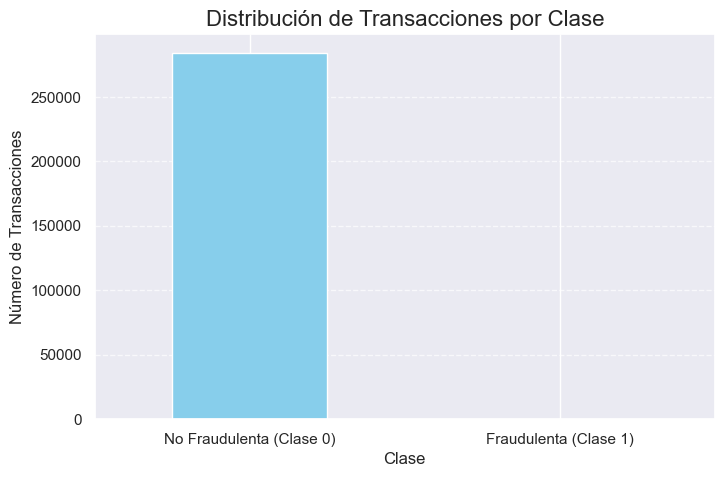

In [146]:
class_counts = df['Class'].value_counts()

# Mostrar conteo en consola
print("Conteo de transacciones por clase:")
print(class_counts)

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Personalizar gráfico
plt.title('Distribución de Transacciones por Clase', fontsize=16)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de Transacciones', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Fraudulenta (Clase 0)', 'Fraudulenta (Clase 1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

In [147]:
porcentaje_fraude = df['Class'].value_counts(normalize=True)[1] * 100  
porcentaje_no_fraude = df['Class'].value_counts(normalize=True)[0] * 100 

print(f"Porcentaje de transacciones fraudulentas: {porcentaje_fraude:.2f}%")
print(f"Porcentaje de transacciones no fraudulentas: {porcentaje_no_fraude:.2f}%")

Porcentaje de transacciones fraudulentas: 0.17%
Porcentaje de transacciones no fraudulentas: 99.83%


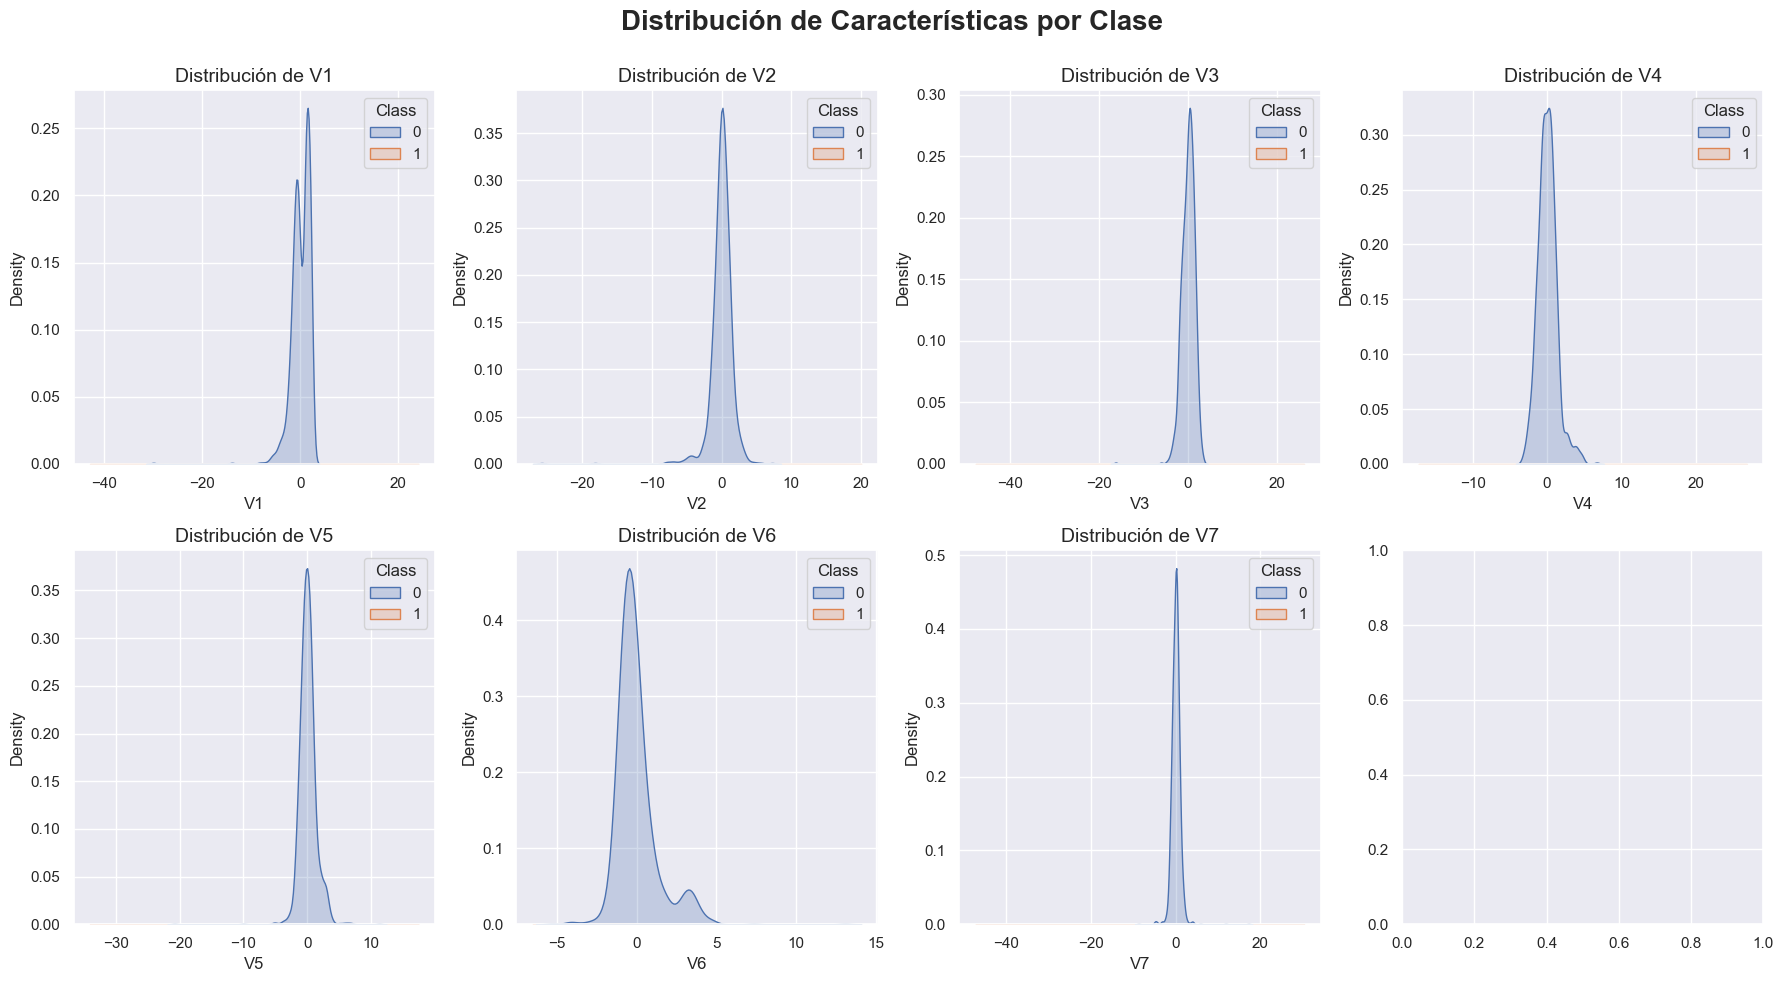

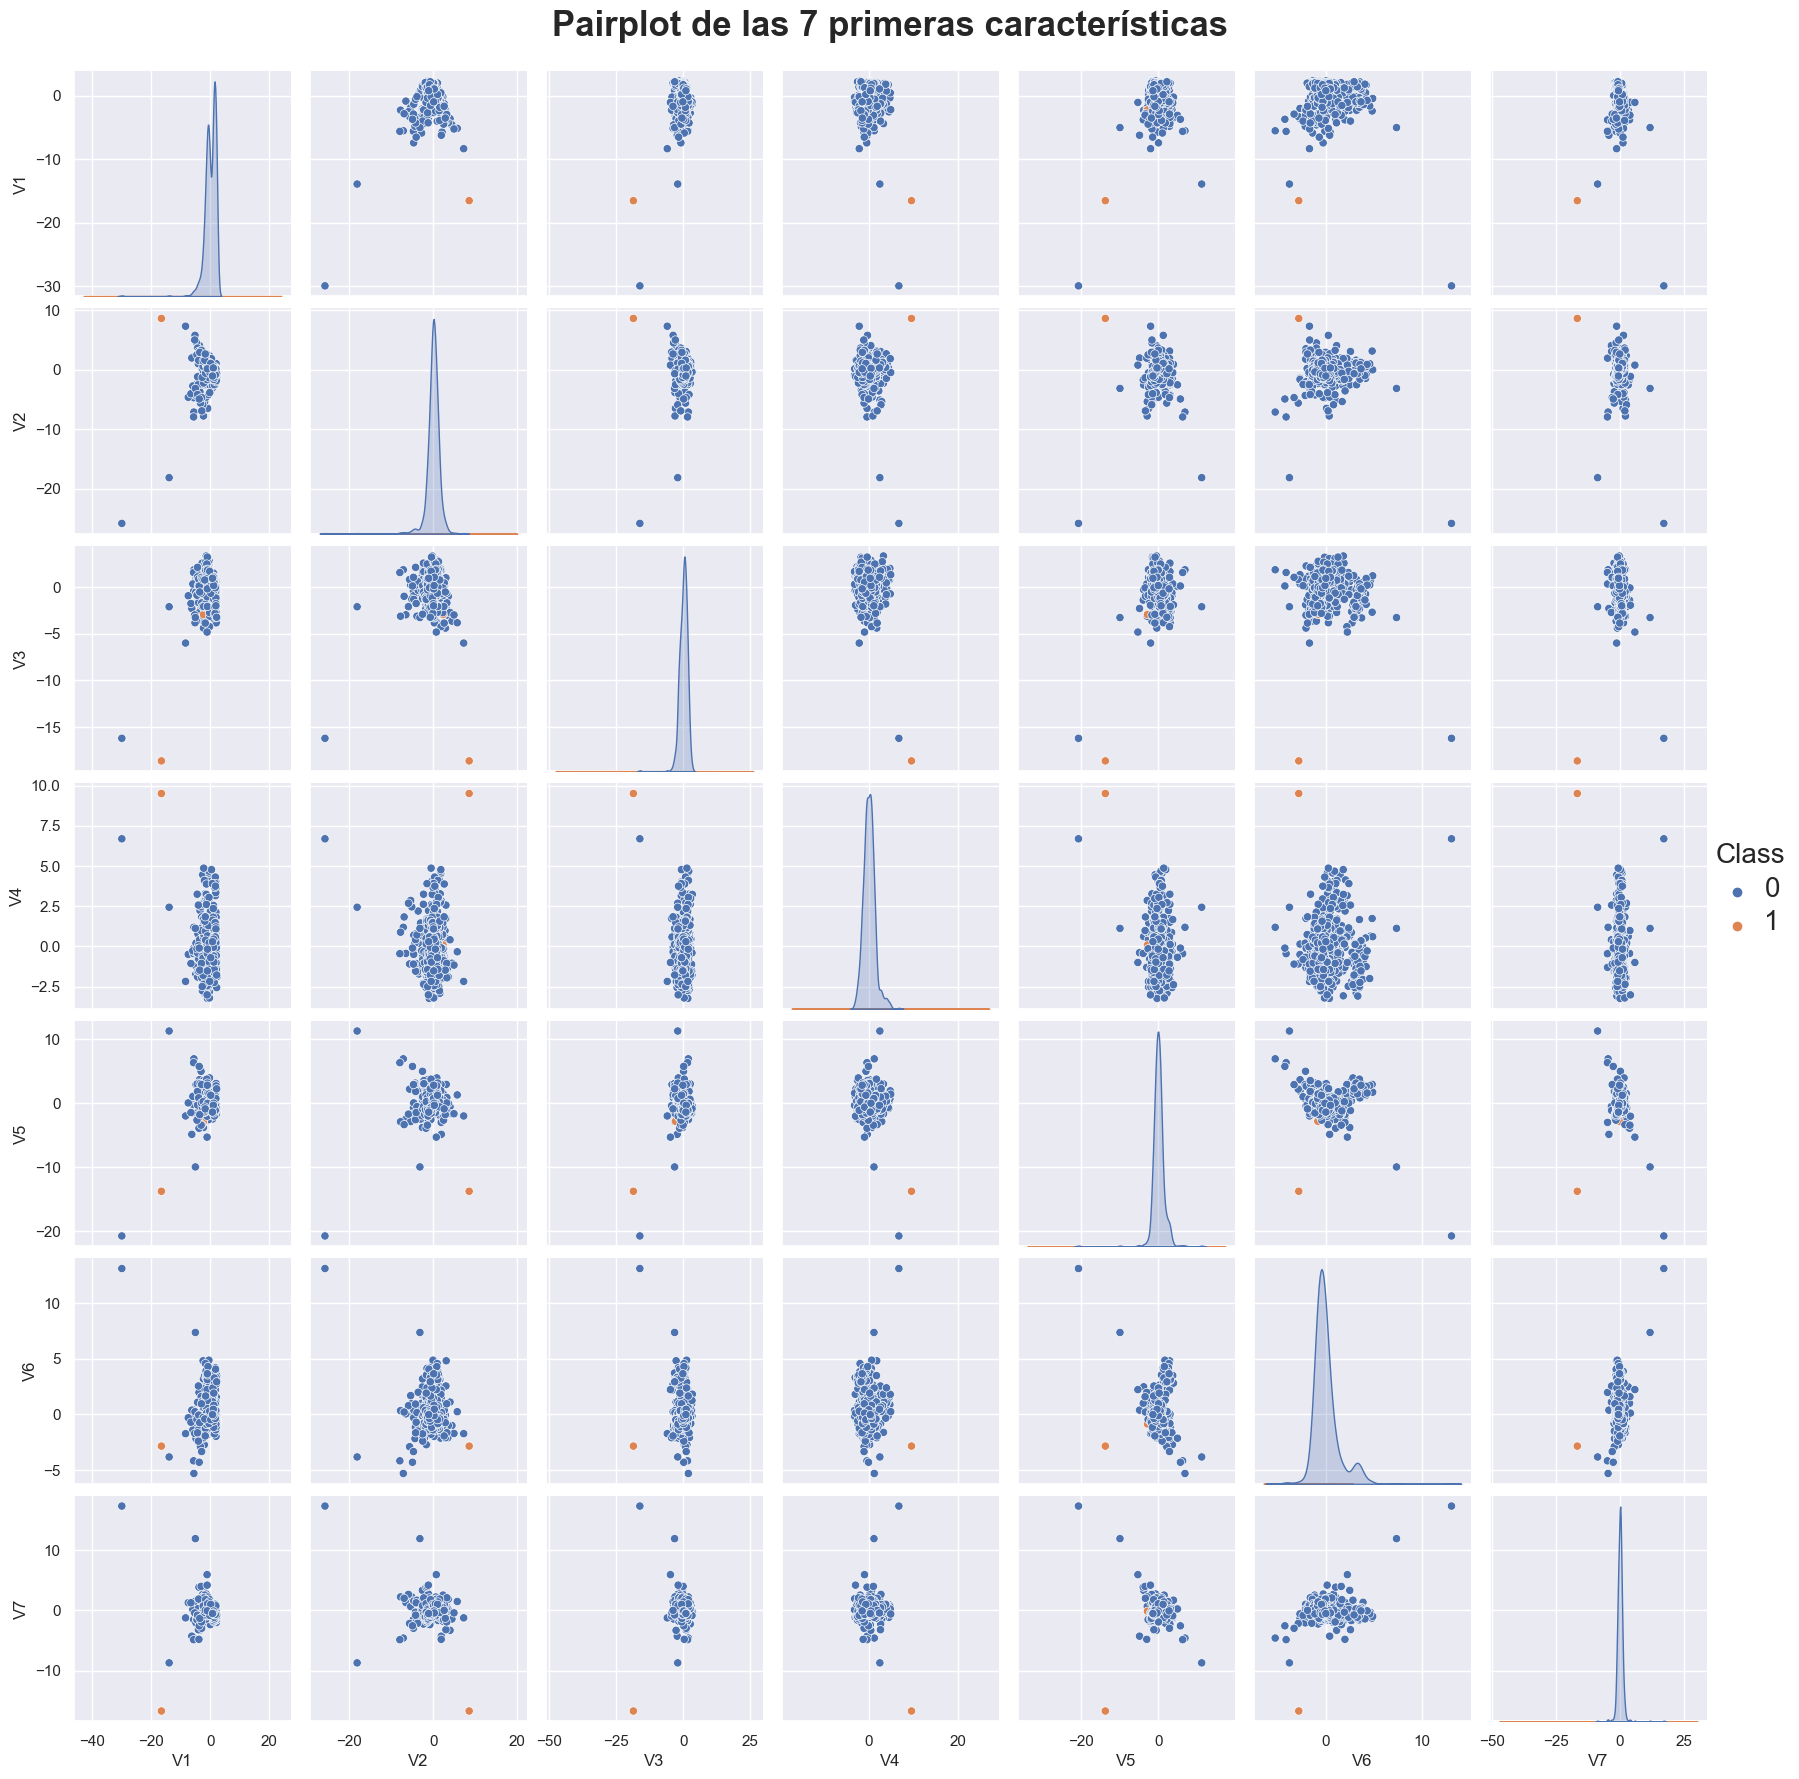

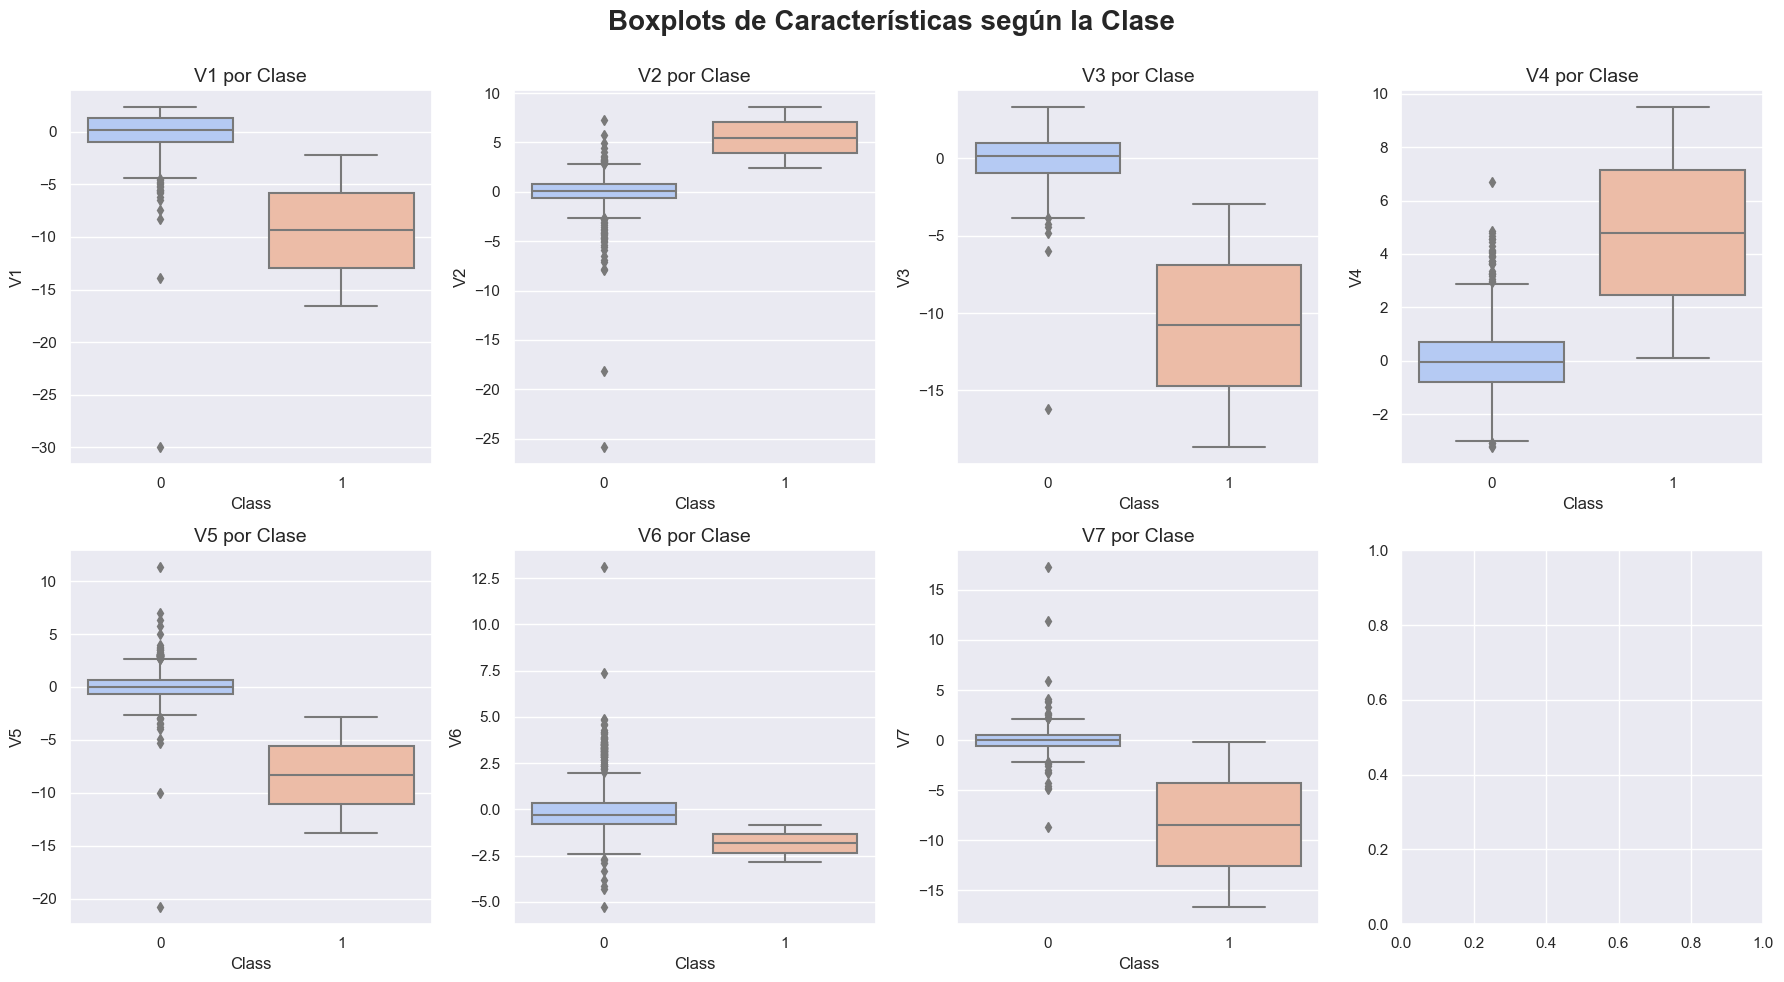

In [148]:
# Selecciono 7 features y el target
selected_features = ['V' + str(i) for i in range(1, 8)] + ['Class']

# Tomo un muestreo aleatorio de 1000 filas
sampled_df = df[selected_features].sample(1000, random_state=42)



# Distribución de Características por Clase
fig, axes = plt.subplots(2, 4, figsize=(18, 10))  
fig.suptitle("Distribución de Características por Clase", fontsize=20, weight='bold')

for i, feature in enumerate(selected_features[:-1]):  # Excluimos 'Class'
    row, col = divmod(i, 4)
    sns.kdeplot(data=sampled_df, x=feature, hue='Class', fill=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribución de {feature}", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# Pairplot
pairplot = sns.pairplot(
    sampled_df,
    hue='Class',
    diag_kind='kde',
    corner=False
)
plt.suptitle('Pairplot de las 7 primeras características', y=1.02, fontsize=25, weight='bold')
plt.setp(pairplot._legend.get_texts(), fontsize=20)  
plt.setp(pairplot._legend.get_title(), fontsize=20)  
plt.show()


# Boxplots por Clase
fig, axes = plt.subplots(2, 4, figsize=(18, 10))  
fig.suptitle("Boxplots de Características según la Clase", fontsize=20, weight='bold')

for i, feature in enumerate(selected_features[:-1]):  
    row, col = divmod(i, 4)
    sns.boxplot(x='Class', y=feature, data=sampled_df, ax=axes[row, col], palette="coolwarm")
    axes[row, col].set_title(f"{feature} por Clase", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


El gráfico visualiza las relaciones entre las primeras 7 características (V1 a V7) del conjunto de datos, segmentadas por la variable objetivo Class. Los gráficos en la diagonal muestran la distribución de densidad de cada característica individual, con picos claros para ambas clases: Class = 0 (no fraudulenta) y Class = 1 (fraudulenta).

Observaciones clave:
La mayoría de las características muestran un solapamiento significativo entre las dos clases, particularmente en V5 y V6, lo que indica dificultades para diferenciar transacciones fraudulentas de no fraudulentas usando solo estas características.
Los diagramas de dispersión entre pares de características, como V1 y V2, revelan una ligera agrupación de las transacciones fraudulentas (Class = 1), lo que sugiere cierta posibilidad de separabilidad.
Aunque las transacciones fraudulentas son raras, los agrupamientos distintos en ciertas combinaciones de características indican oportunidades para el modelado predictivo.
Este análisis sugiere la necesidad de:

Feature engineering para mejorar la separación entre las clases.
Técnicas de re-muestreo como SMOTE para abordar el desequilibrio y mejorar el rendimiento del modelo.

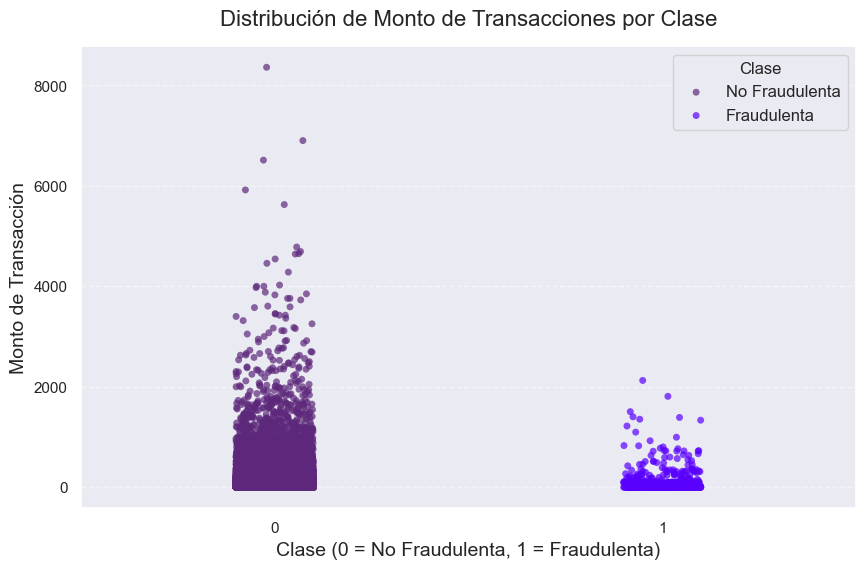

In [149]:
# Transacciones fraudulentas y no fraudulentas
fraude = df[df['Class'] == 1]
no_fraude = df[df['Class'] == 0]

#Creamos un subconjunto balanceado para el scatterplot
balanced_no_fraude_scatter = no_fraude.sample(len(fraude) * 100, random_state=42)
balanced_df_scatter = pd.concat([fraude, balanced_no_fraude_scatter])

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=balanced_df_scatter,
    x='Class',
    y='Amount',
    hue='Class',
    palette=['#5D287B', '#5900FF'],
    jitter=True,
    alpha=0.7
)

plt.title('Distribución de Monto de Transacciones por Clase', fontsize=16, pad=15)
plt.xlabel('Clase (0 = No Fraudulenta, 1 = Fraudulenta)', fontsize=14)
plt.ylabel('Monto de Transacción', fontsize=14)
plt.legend(title='Clase', labels=['No Fraudulenta', 'Fraudulenta'], loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

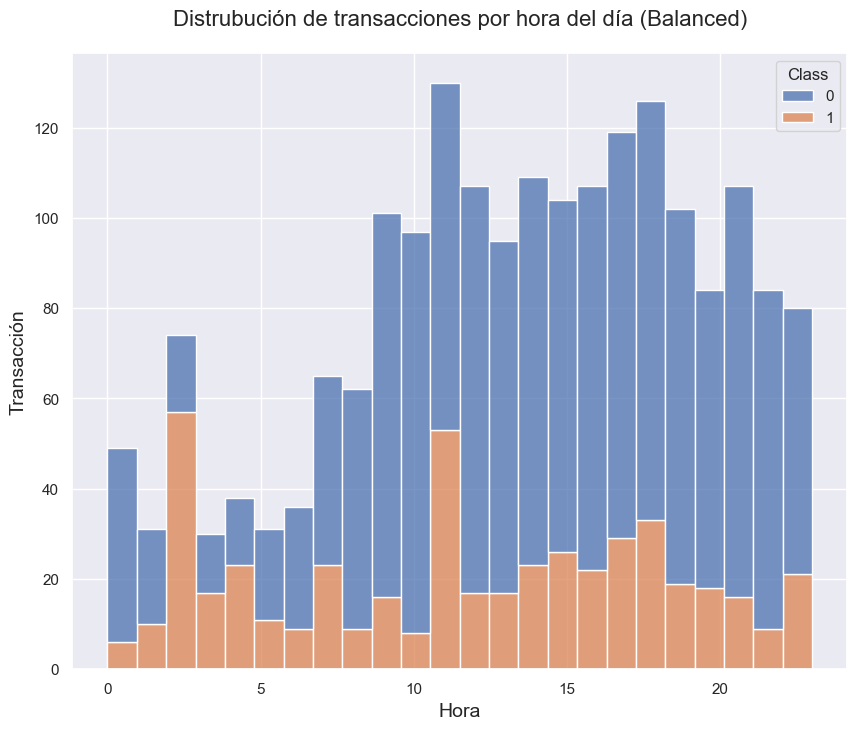

In [150]:
fraude = df[df['Class'] == 1]
no_fraude = df[df['Class'] == 0]

# Acá hago un sampleo de las transacciones que no son fraudulentas
balanced_no_fraude = no_fraude.sample(len(fraude)*3, random_state=42)

# Acá combino ambos
balanced_df = pd.concat([fraude, balanced_no_fraude])

# Para obtener la hora ya que la columna Time es en segundos
balanced_df['Hour'] = (balanced_df['Time'] // 3600) % 24

plt.figure(figsize=(10,8))
sns.histplot(data=balanced_df, x='Hour', hue='Class', multiple='stack', bins=24)

# Add title and labels
plt.title('Distrubución de transacciones por hora del día (Balanced)', fontsize=16,pad = 20)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Transacción', fontsize=14)

# Show the plot
plt.show()

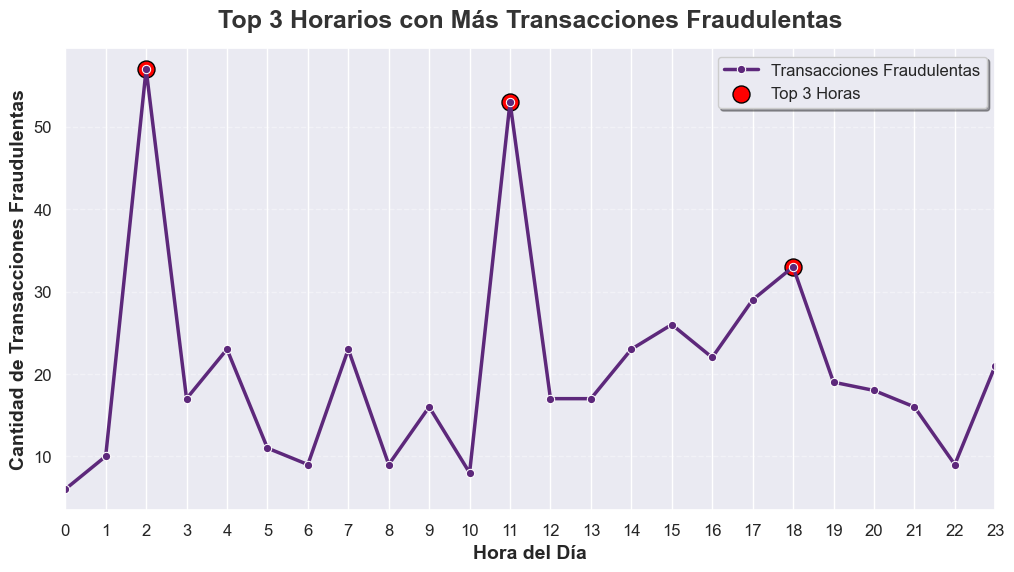

In [151]:

hourly_fraud = balanced_df[balanced_df["Class"] == 1].groupby("Hour").size()

top_hours = hourly_fraud.nlargest(3).index

plt.figure(figsize=(12, 6))

sns.lineplot(data=hourly_fraud, x=hourly_fraud.index, y=hourly_fraud.values, marker="o",
             color="#5D287B", linewidth=2.5, label="Transacciones Fraudulentas")

sns.scatterplot(x=top_hours, y=hourly_fraud.loc[top_hours], color="red", s=150, edgecolor="black", label="Top 3 Horas")

plt.xticks(np.arange(0, 24, step=1), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 23)
plt.grid(axis='y', linestyle='dashed', alpha=0.4)

plt.title('Top 3 Horarios con Más Transacciones Fraudulentas', fontsize=18, weight='bold', pad=15, color='#333')
plt.xlabel('Hora del Día', fontsize=14, weight='bold')
plt.ylabel('Cantidad de Transacciones Fraudulentas', fontsize=14, weight='bold')

plt.legend(fontsize=12, frameon=True, shadow=True)

plt.show()

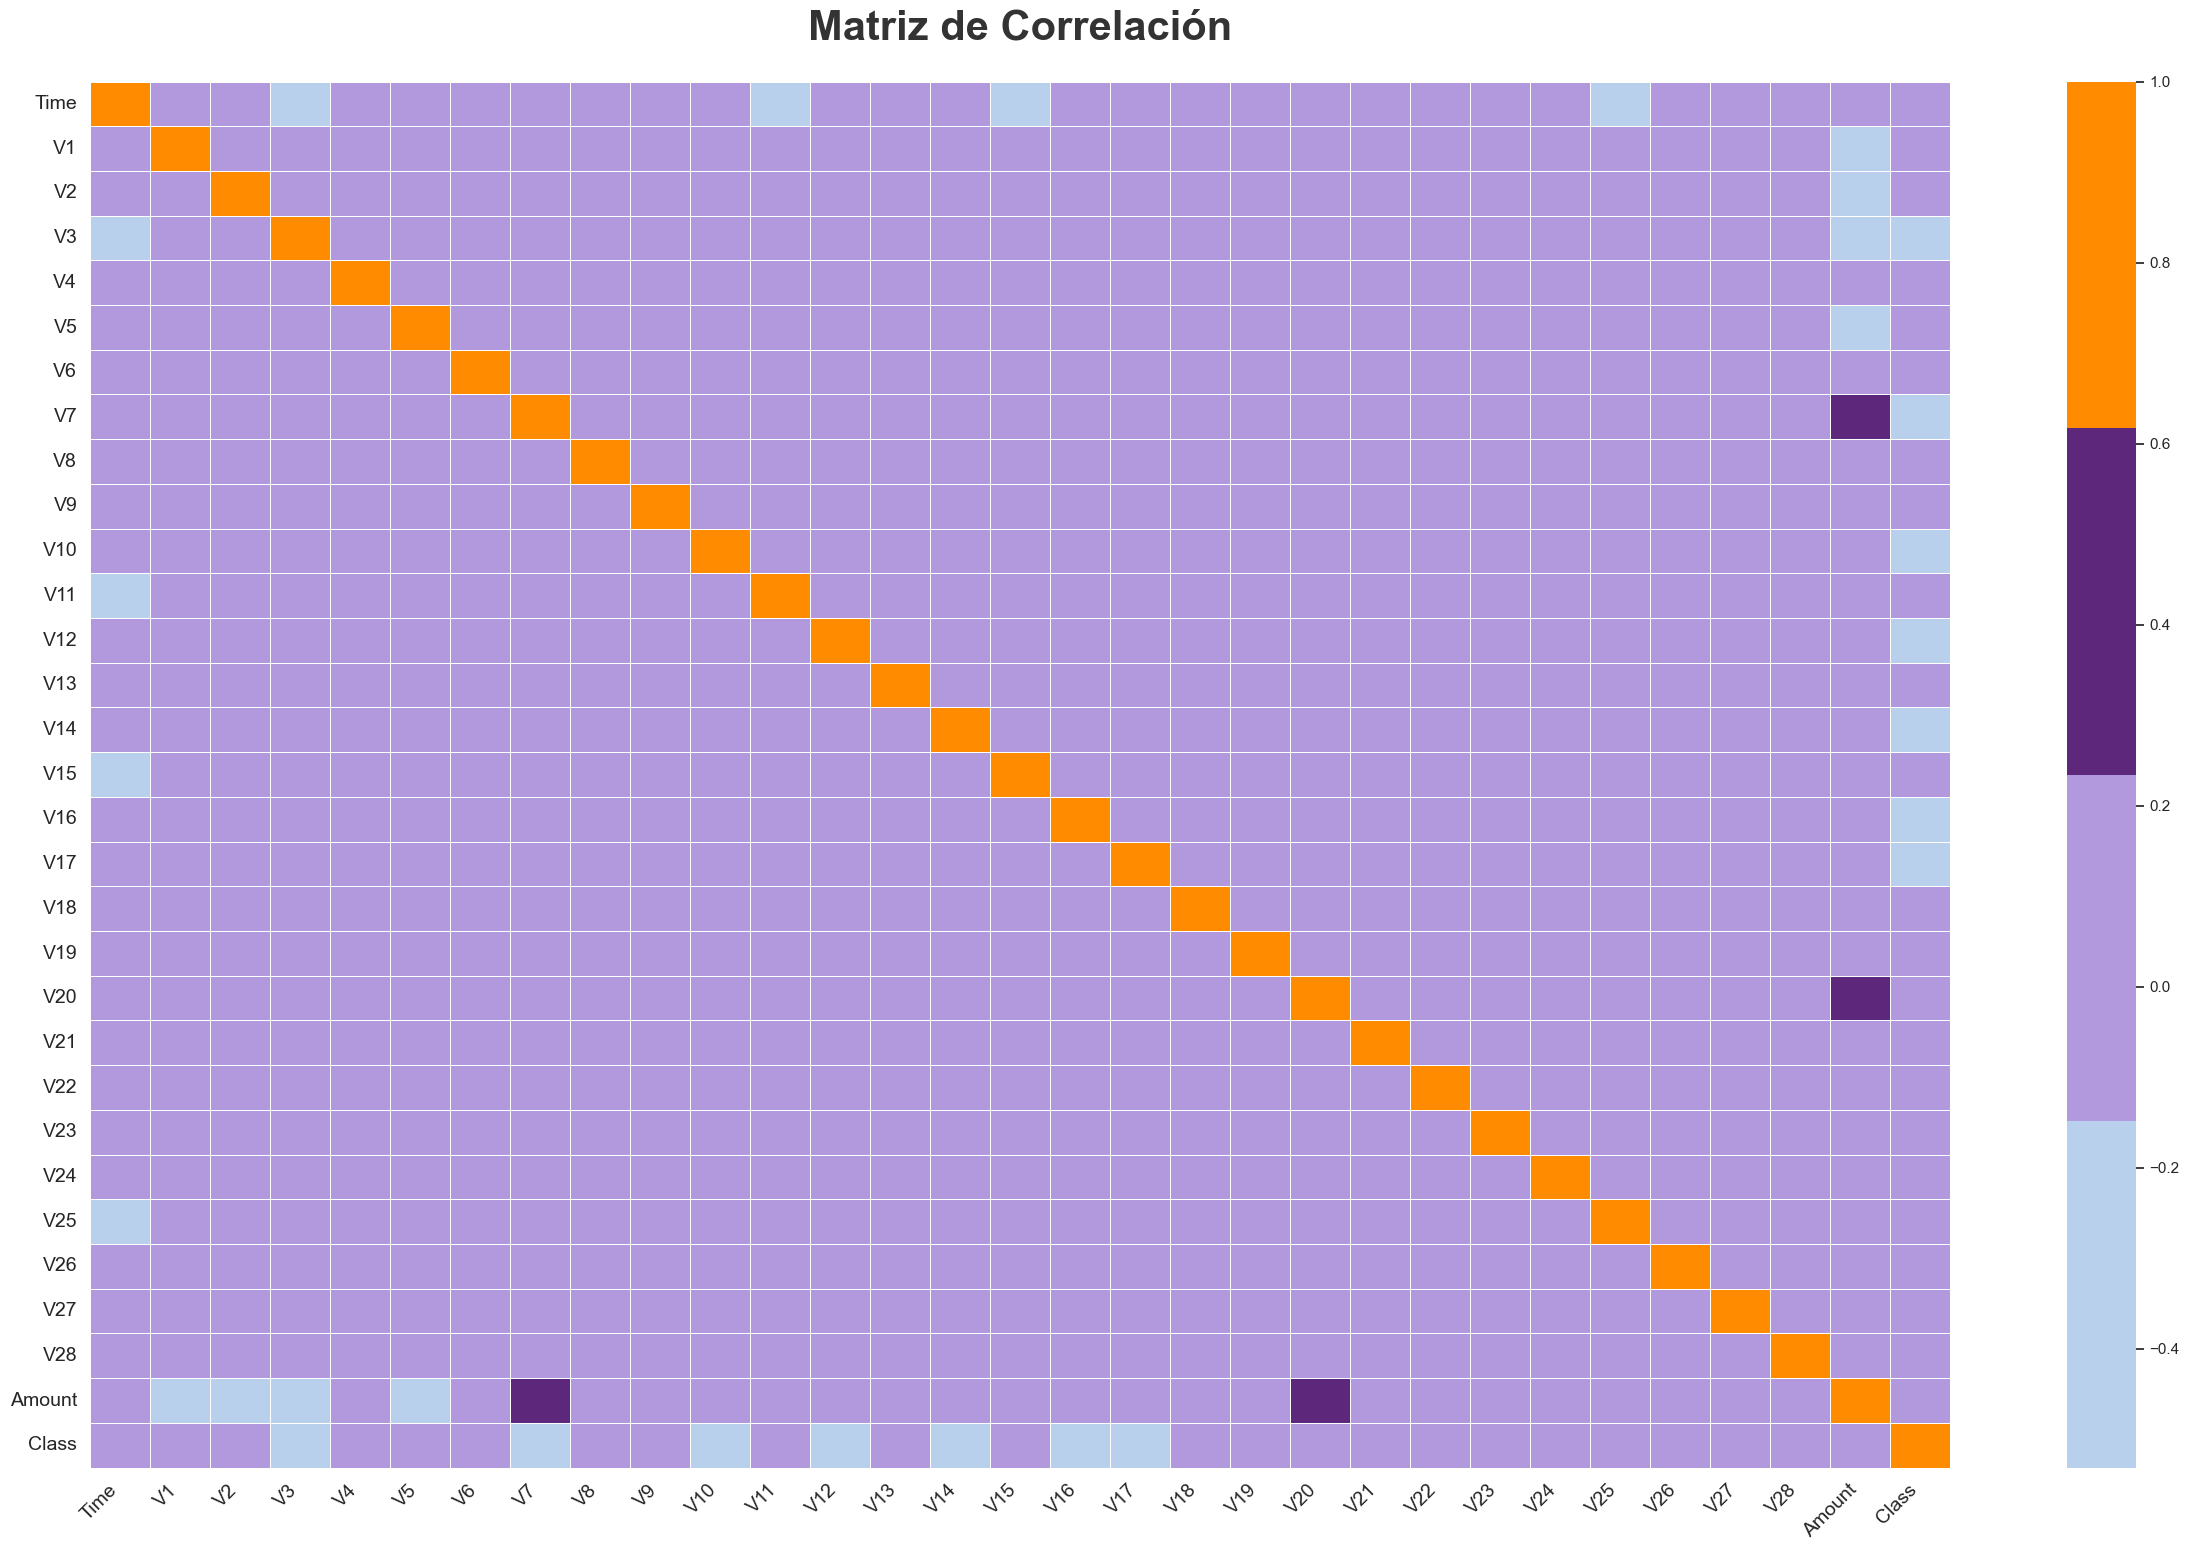

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

custom_palette = ['#B8D0EB', '#B298DC', '#5D287B', '#FF8C00']


plt.figure(figsize=(30, 18)) 
sns.heatmap(
    correlation_matrix,

    fmt=".2f",
    cmap=sns.color_palette(custom_palette, as_cmap=True), 
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12},  
)


plt.xticks(fontsize=14, rotation=45, ha="right")
plt.yticks(fontsize=14)
plt.title("Matriz de Correlación", fontsize=30, weight='bold', color="#333333", pad=30)
plt.show()


In [153]:
correlation_matrix = df.corr()

print("Matriz de Correlación entre las Variables:")
print(correlation_matrix.to_string(float_format="%.2f")) 


Matriz de Correlación entre las Variables:
        Time    V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11   V12   V13   V14   V15   V16   V17   V18   V19   V20   V21   V22   V23   V24   V25   V26   V27   V28  Amount  Class
Time    1.00  0.12 -0.01 -0.42 -0.11  0.17 -0.06  0.08 -0.04 -0.01  0.03 -0.25  0.12 -0.07 -0.10 -0.18  0.01 -0.07  0.09  0.03 -0.05  0.04  0.14  0.05 -0.02 -0.23 -0.04 -0.01 -0.01   -0.01  -0.01
V1      0.12  1.00  0.00 -0.00 -0.00  0.00 -0.00 -0.00 -0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00   -0.23  -0.10
V2     -0.01  0.00  1.00  0.00 -0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00 -0.00  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00   -0.53   0.09
V3     -0.42 -0.00  0.00  1.00  0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00 -0.00 -0.00  0.0

Variables con mayor correlación con "Class" (que es la variable de salida):
V11 (-0.25), V3 (-0.42), V25 (-0.23), V10 (-0.22), V26 (-0.04), V7 (0.40) muestran correlaciones moderadas.

Variables con correlaciones altas entre ellas:
V2, V4, V5, y varias otras tienen correlaciones muy bajas entre sí (alrededor de 0), por lo que parece que no hay una relación fuerte entre ellas.

Variables con correlaciones bajas o nulas:
Muchas variables como V1, V2, V5, etc., tienen correlaciones muy pequeñas, lo que podría indicar que no contribuyen significativamente a la variabilidad en las otras variables.

Variable "Amount" tiene correlaciones moderadas con algunas variables como V2 (-0.53) y V5 (-0.39), lo que podría sugerir que "Amount" tiene un efecto sobre algunas de las características numéricas del dataset.

Pero tomando en cuenta el PCA aplicado, esto toma sentido

In [154]:
df['Hora'] = (df['Time'] // 3600) % 24
df['Minuto'] = (df['Time'] // 60) % 60
df['Segundo'] = df['Time'] % 60
df['EsDia'] = df['Hora'].apply(lambda x: 1 if 6 <= x < 18 else 0)


def parte_dia(Hora):
    if 6 <= Hora < 12:
        return 'Mañana'
    elif 12 <= Hora < 18:
        return 'Tarde'
    elif 18 <= Hora < 24:
        return 'Tardecita'
    else:
        return 'Noche'

df['ParteDia'] = df['Hora'].apply(parte_dia)


df['TransaccionFase'] = pd.qcut(df['Time'], q=4, labels=['Temprano', 'MedioDia', 'Tarde', 'Final'])


df['ActividadNivel'] = df['Hora'].map(df['Hora'].value_counts())

df['LogTime'] = np.log1p(df['Time'])

df.drop(columns=['Time'])

df = pd.get_dummies(df, columns=['TransaccionFase', 'ParteDia'], drop_first=True)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,Segundo,EsDia,ActividadNivel,LogTime,TransaccionFase_MedioDia,TransaccionFase_Tarde,TransaccionFase_Final,ParteDia_Noche,ParteDia_Tarde,ParteDia_Tardecita
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.0,0,7695,0.000000,False,False,False,True,False,False
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.0,0,7695,0.000000,False,False,False,True,False,False
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,1.0,0,7695,0.693147,False,False,False,True,False,False
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,1.0,0,7695,0.693147,False,False,False,True,False,False
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,2.0,0,7695,1.098612,False,False,False,True,False,False


In [155]:
X, y = df.drop('Class', axis=1), df['Class']
print("Balanceo de clase antes de  SMOTE:")
print(pd.Series(y.value_counts()))

Balanceo de clase antes de  SMOTE:
Class
0    284315
1       492
Name: count, dtype: int64


In [156]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
print("Balanceo de clase después de SMOTE:")
print(pd.Series(y_resampled).value_counts())

Balanceo de clase después de SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64


In [157]:
#Vamos a tomar ahora un undersampler para trabajar con clases más pequeñas


# Combinamos X e y en un solo Dataframe para mejor y más rápido procesamiento¿
data = X_resampled.copy()
data['Target'] = y_resampled

# Usamos el RandomUnderSampler
reduction_factor = 0.01  # El factor de reducción (1%)
desired_sample_size = int(len(data) * reduction_factor)  
sampler = RandomUnderSampler(
    sampling_strategy={0: desired_sample_size // 2, 1: desired_sample_size // 2}, 
    random_state=42 
)


X_reduced, y_reduced = sampler.fit_resample(data.drop(columns=['Target']), data['Target'])

X_reduced = pd.DataFrame(X_reduced, columns=X_resampled.columns)  #
y_reduced = pd.Series(y_reduced, name='Сlass')  

print("Clases balanceadas luego de  RandomUnderSampler:")
print(y_reduced.value_counts())



Clases balanceadas luego de  RandomUnderSampler:
Сlass
0    2843
1    2843
Name: count, dtype: int64


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [159]:
model_metrics = []
feature_importance_list = [] 

def evaluate_and_visualize(model, X_train, X_test, y_train, y_test):
    global model_metrics, feature_importance_list

  
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    score_train = round(accuracy_score(y_train, y_pred_train) * 100, 3)
    score_test = round(accuracy_score(y_test, y_pred_test) * 100, 3)
    print(f"\nScore de accuracy de entrenamiento y test:")
    print(f"\t>> Entrenamiento Accuracy: {score_train}%")
    print(f"\t>> Test Accuracy: {score_test}%")

    report = classification_report(y_test, y_pred_test, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    accuracy = accuracy_score(y_test, y_pred_test)

    model_metrics.append({
        "Model": model.__class__.__name__,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Accuracy": accuracy
    })

   
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # --- Gráfico 1: Top 7 de Feature Importances 
    if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        if hasattr(model, 'coef_'):
            feature_importances = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_

        top_features = np.argsort(feature_importances)[-7:][::-1]
        feature_importance_list.append({
            "Model": model.__class__.__name__,
            "Feature Importances": {f"V{i}": feature_importances[i] for i in top_features}
        })

        axes[0, 0].barh(range(len(top_features)), feature_importances[top_features], color='#107ACC')
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels([f'V {i}' for i in top_features])
        axes[0, 0].set_xlabel('Importance')
        axes[0, 0].set_title('Top 7 de Feature Importances', pad=10)
        axes[0, 0].invert_yaxis()
        axes[0, 0].grid(axis='x')
    else:
        axes[0, 0].axis('off')
        axes[0, 0].set_title('Feature importance no está disponible', pad=10)

    # --- Gráfico 2: Matriz de Confusión 
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap=sns.color_palette(["#2898ee", "#0cbccc"]),
        xticklabels=['Fraude', 'No Fraude'],
        yticklabels=['Fraude', 'No Fraude'],
        cbar=False, 
        annot_kws={"color": "white", "fontsize": '14'}, 
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Confusion Matrix', pad=10)
    axes[0, 1].set_xlabel('Valores predichos')
    axes[0, 1].set_ylabel('Valores verdaderos')

    # --- Gráfico 3: Curva de Aprendizaje
    def plot_learning_curve(ax, estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        ax.plot(train_sizes, train_mean, label='Score entrenamiento', marker='o', color='#2898ee')
        ax.plot(train_sizes, test_mean, label='Score validación', marker='o', color='#0cbccc')
        ax.set_title('Curva de aprendizaje', pad=10)
        ax.set_xlabel('Tamaño Training Set')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=20)
        ax.grid()

    plot_learning_curve(axes[1, 0], model, X_train, y_train)

    # --- Gráfico 4: Curva ROC-AUC 
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        axes[1, 1].plot(fpr, tpr, color='#0Cbccc', label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[1, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[1, 1].set_title('ROC-AUC Curve', pad=10)
        axes[1, 1].set_xlabel('Rate de falsos positivos')
        axes[1, 1].set_ylabel('Rate de verdaderos positivos')
        axes[1, 1].legend(loc='lower right')
        axes[1, 1].grid()
    else:
        axes[1, 1].axis('off')
        axes[1, 1].set_title('predict_proba no está disponible', pad=10)

    plt.tight_layout()
    plt.show()



Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 97.713%
	>> Test Accuracy: 97.627%


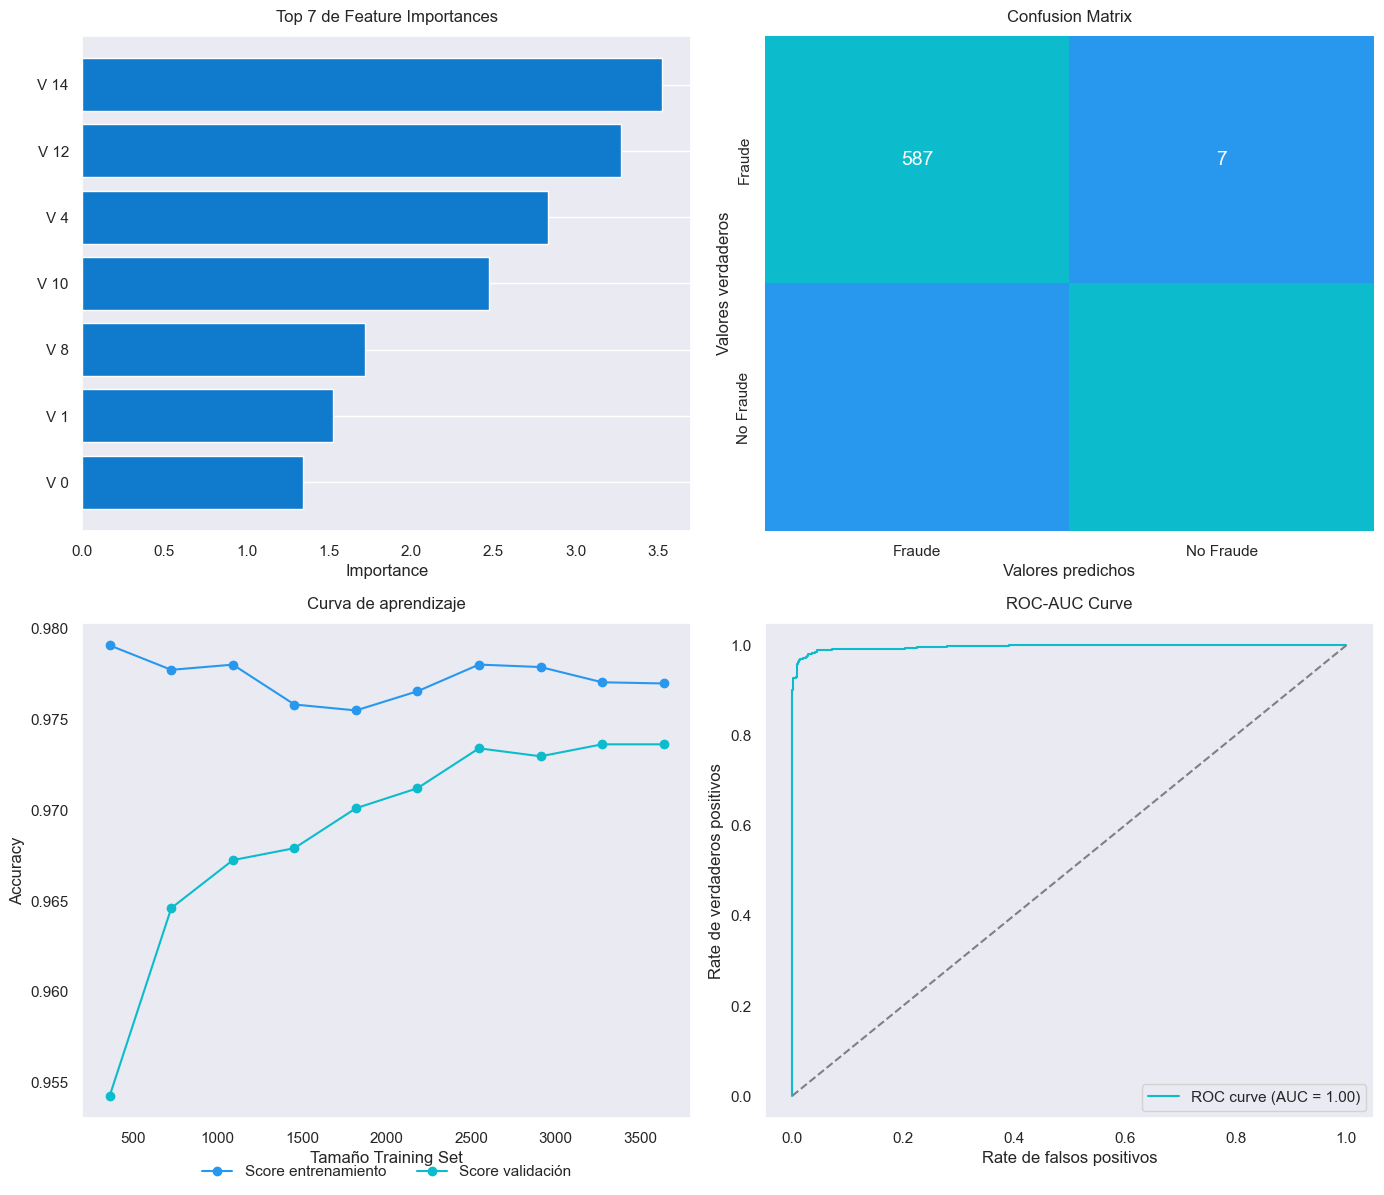

In [160]:
#Comenzamos por regresión logística

log_reg = LogisticRegression(random_state=42, solver='liblinear')

evaluate_and_visualize(log_reg, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 100.0%
	>> Test Accuracy: 98.506%


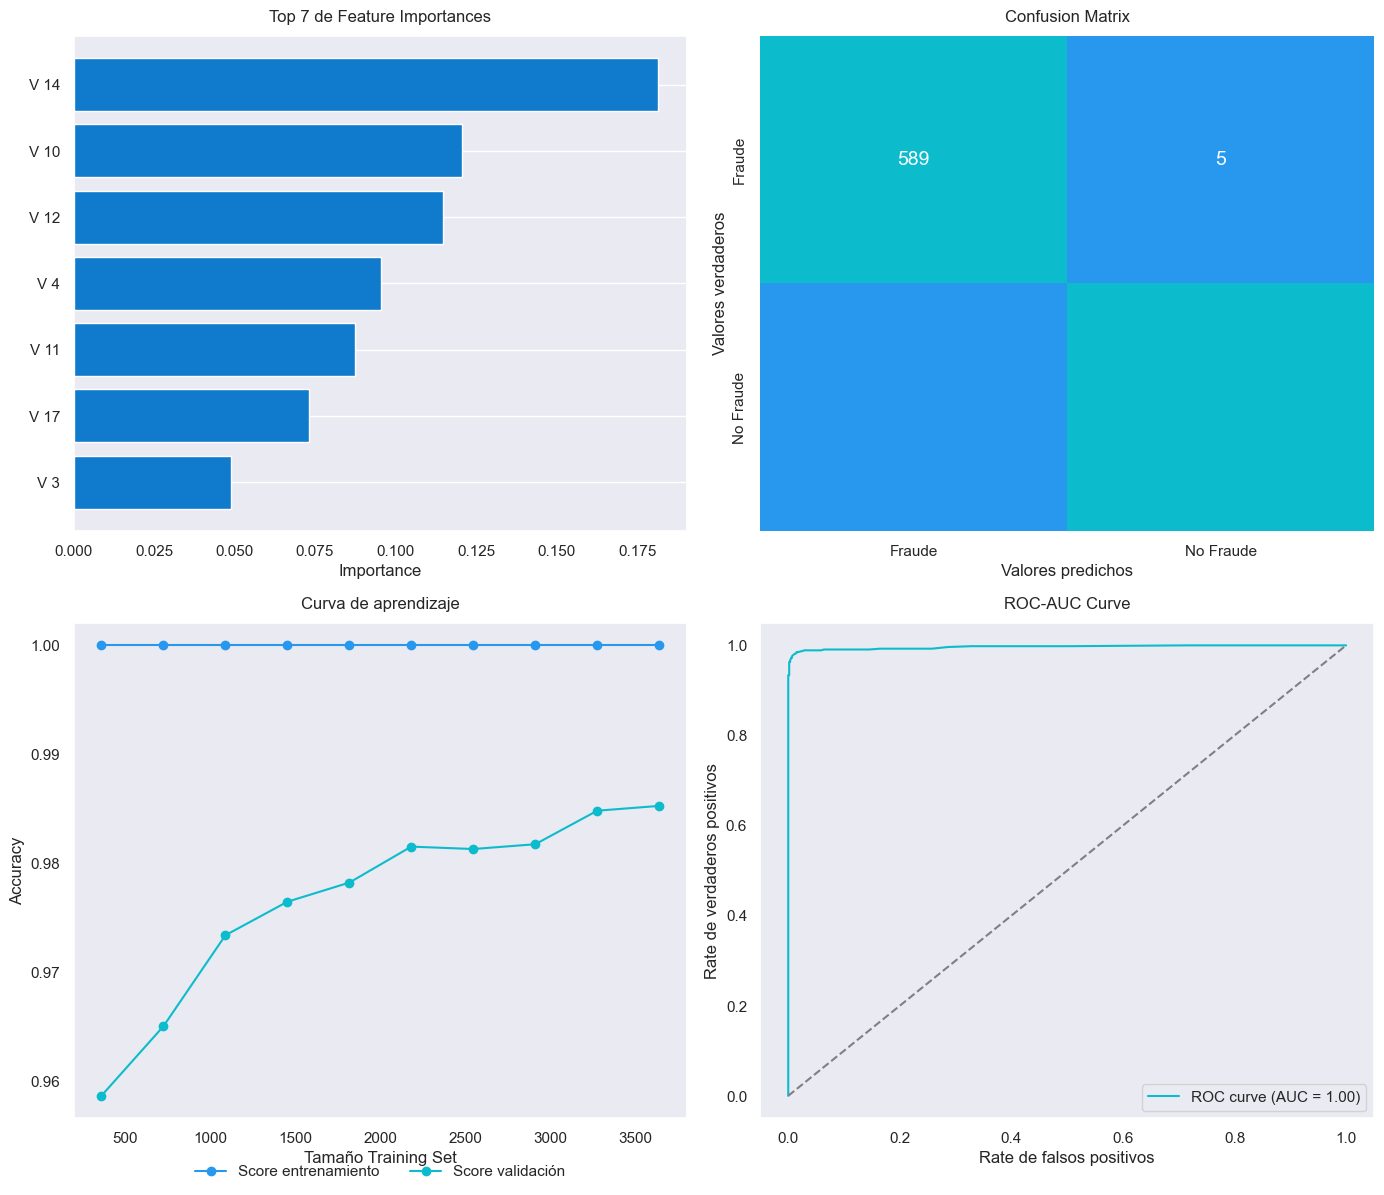

In [161]:
#Clasificador Random Forest
rf = RandomForestClassifier(random_state=42)
evaluate_and_visualize(rf, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 100.0%
	>> Test Accuracy: 99.209%


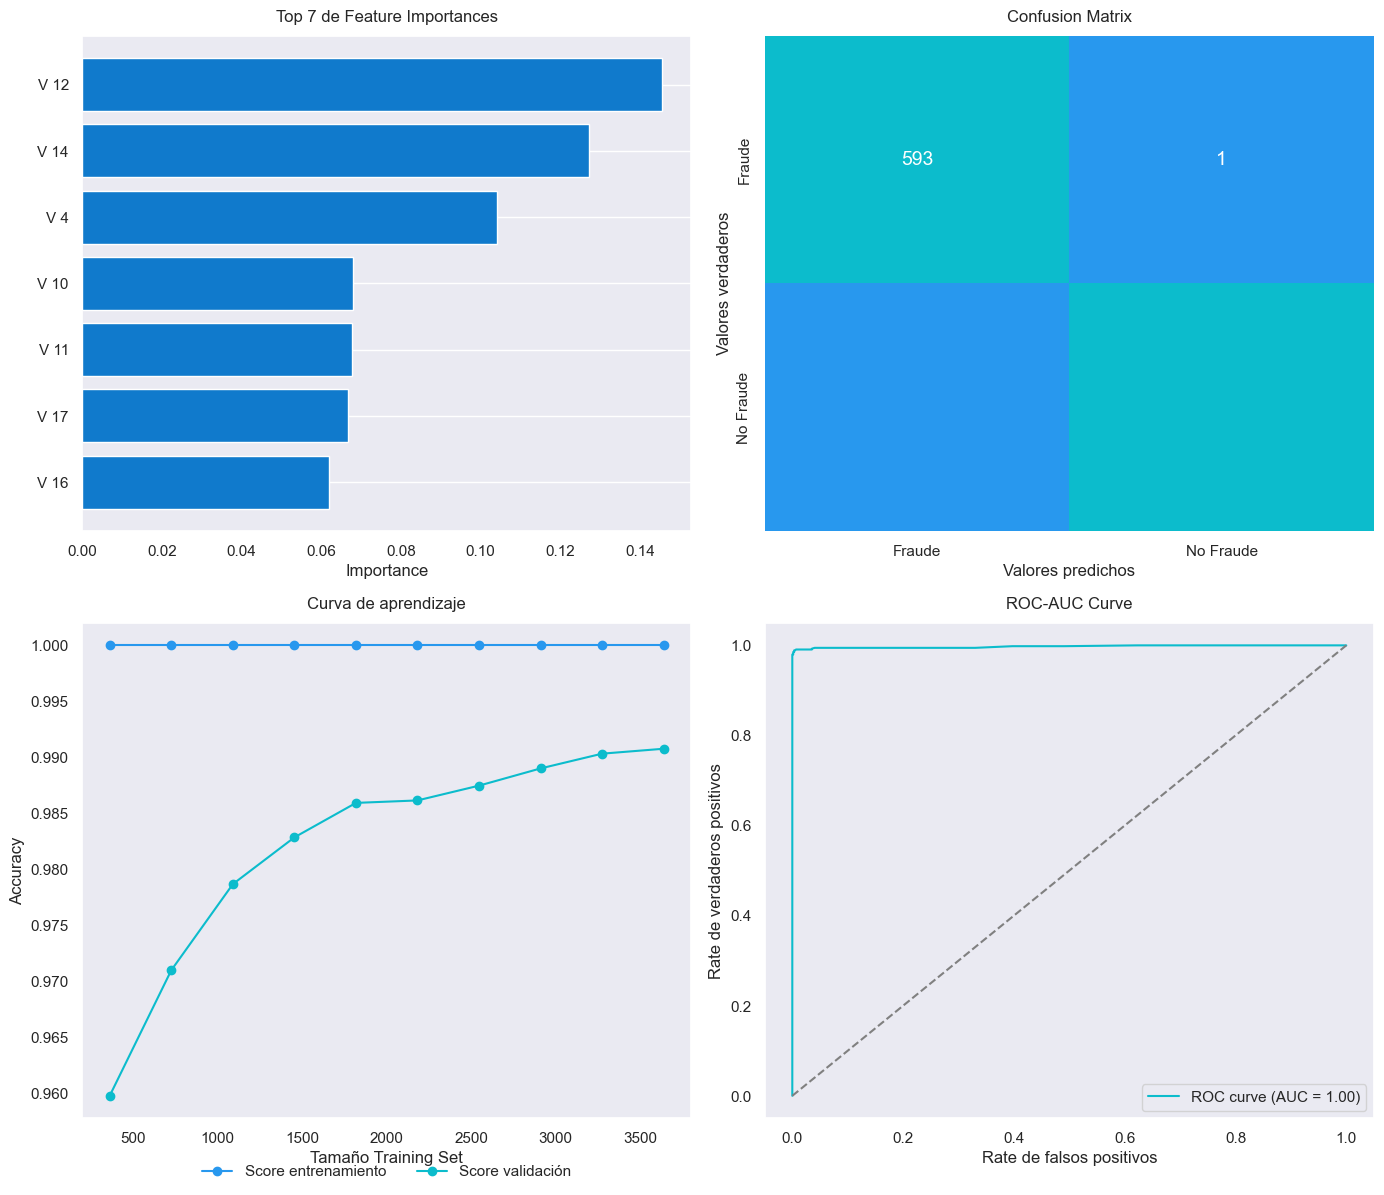

In [162]:
# Clasificador Extra Trees
et = ExtraTreesClassifier(random_state=42)
evaluate_and_visualize(et, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 99.077%
	>> Test Accuracy: 96.749%


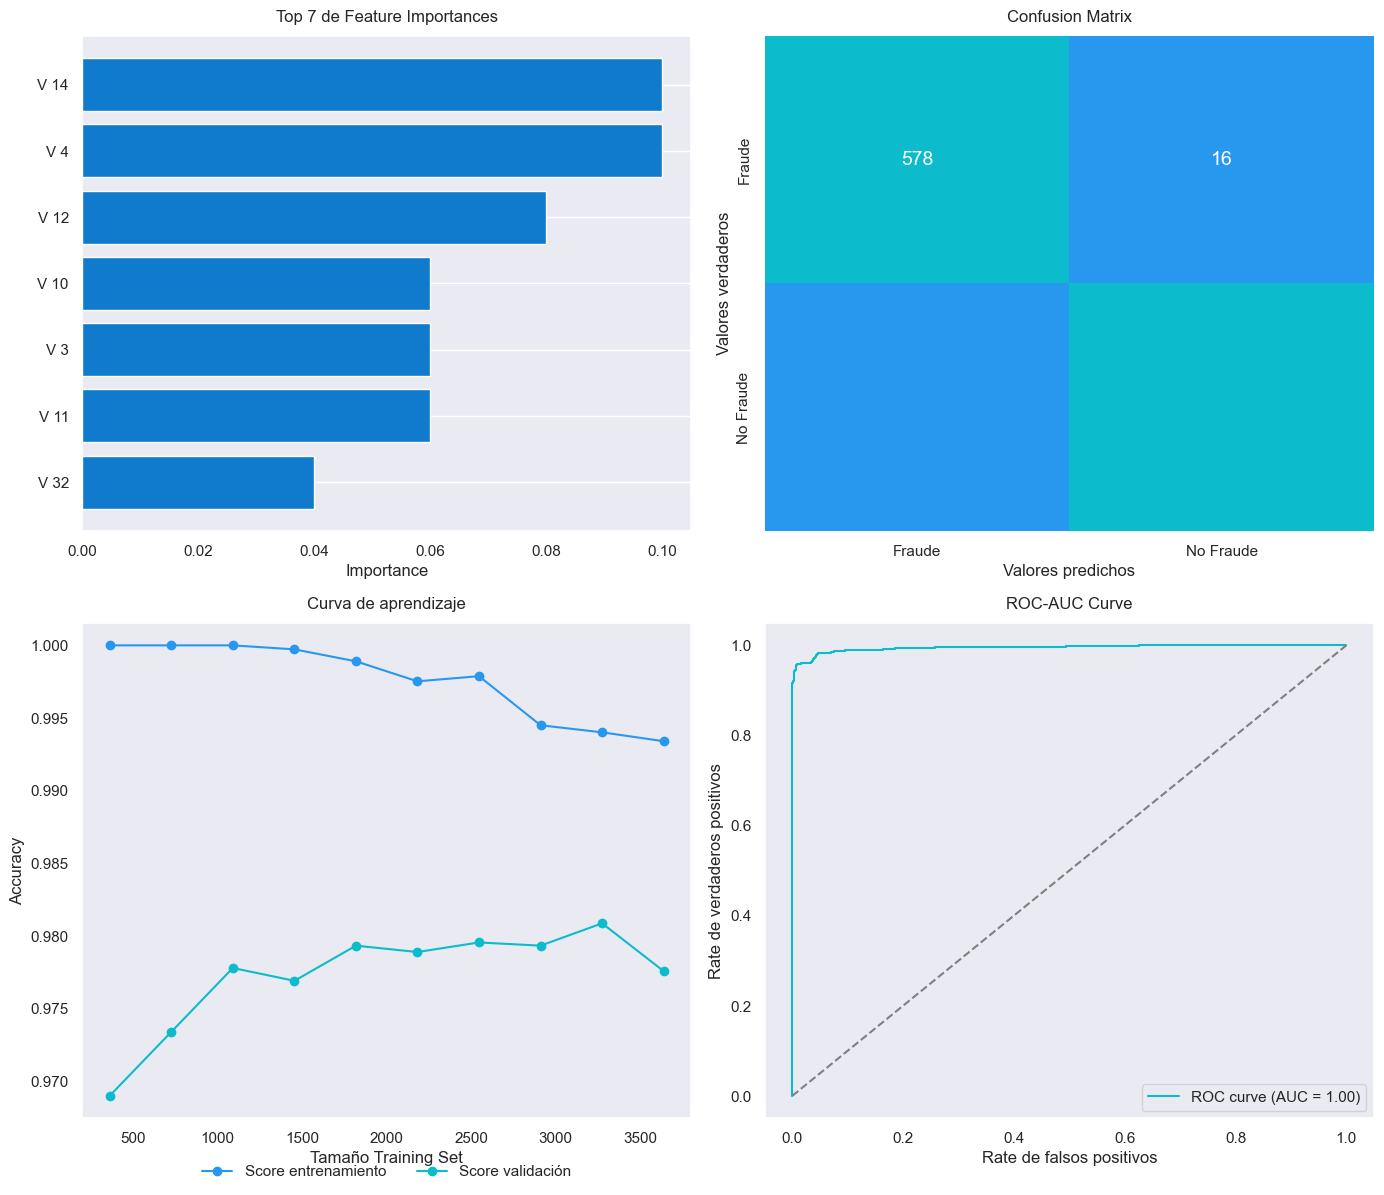

In [163]:
#Ahora aplicar adaboost que es un método ensamble para combinar clasificadores débiles secuencialmente de modo a crear un clasificador fuerte concentrándose más en los puntos de datos mal clasificados

ada = AdaBoostClassifier(random_state=42)
evaluate_and_visualize(ada, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 99.648%
	>> Test Accuracy: 97.979%


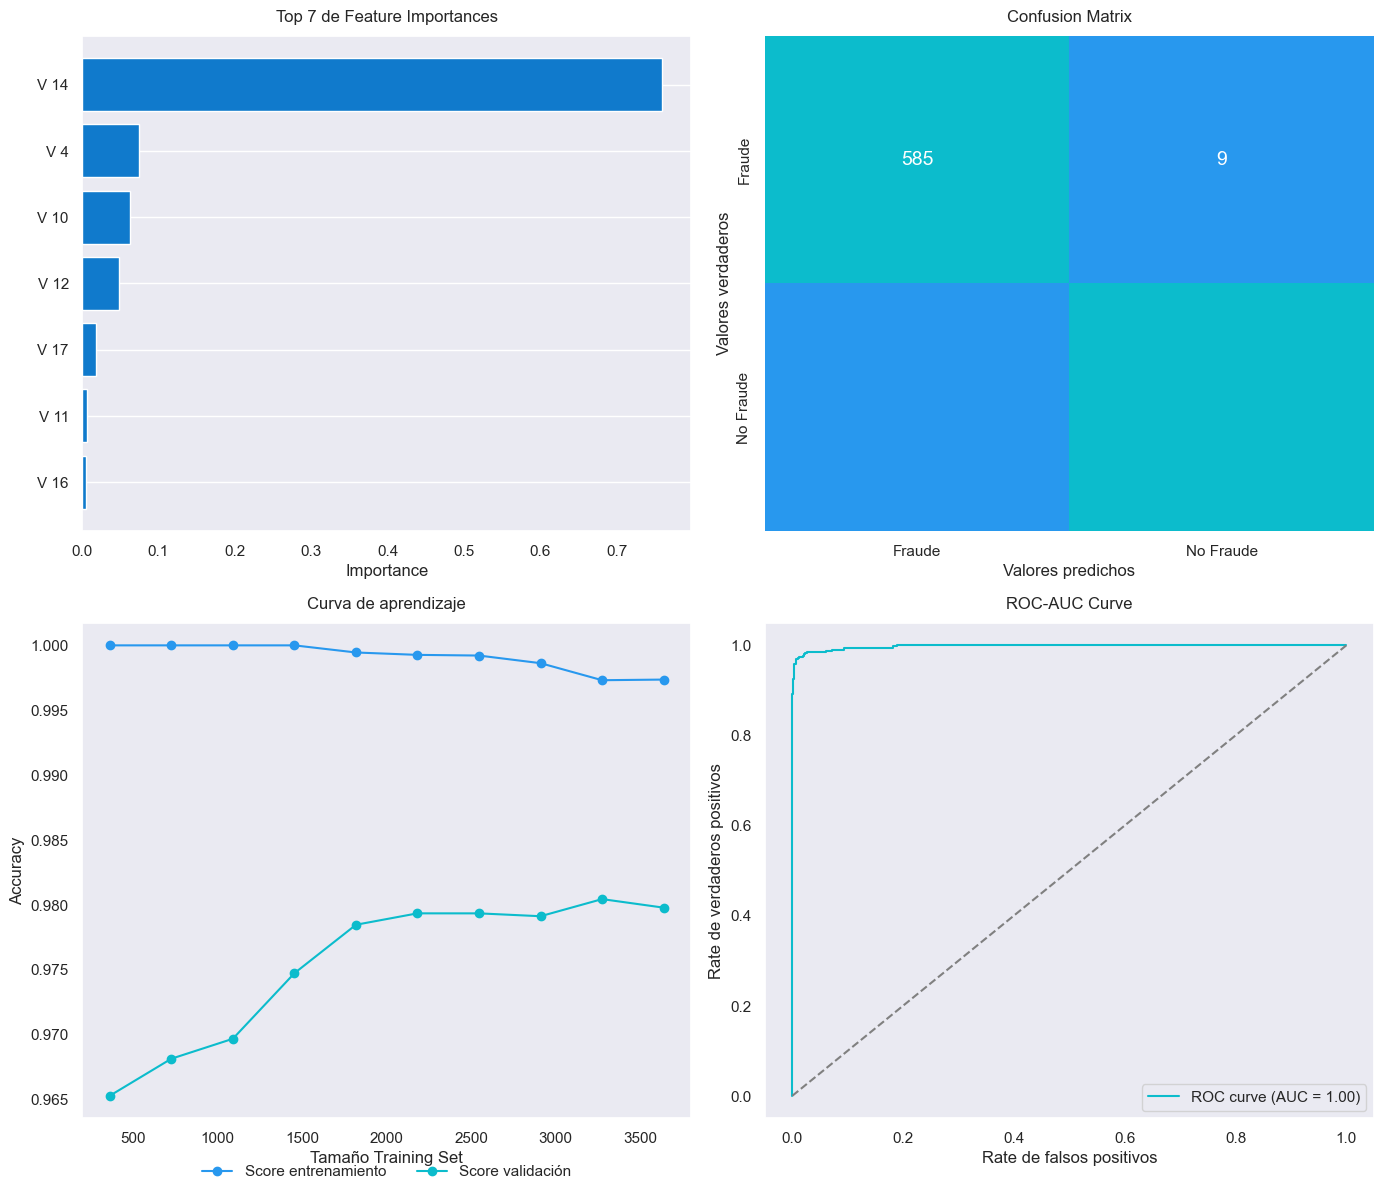

In [164]:
#El método Gradient boosting permite construir modelos secuencialmente, lo cual permite optimizar errores de modelos previos para crear un modelo predictivo potente

gb = GradientBoostingClassifier(random_state=42)
evaluate_and_visualize(gb, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 99.978%
	>> Test Accuracy: 98.77%


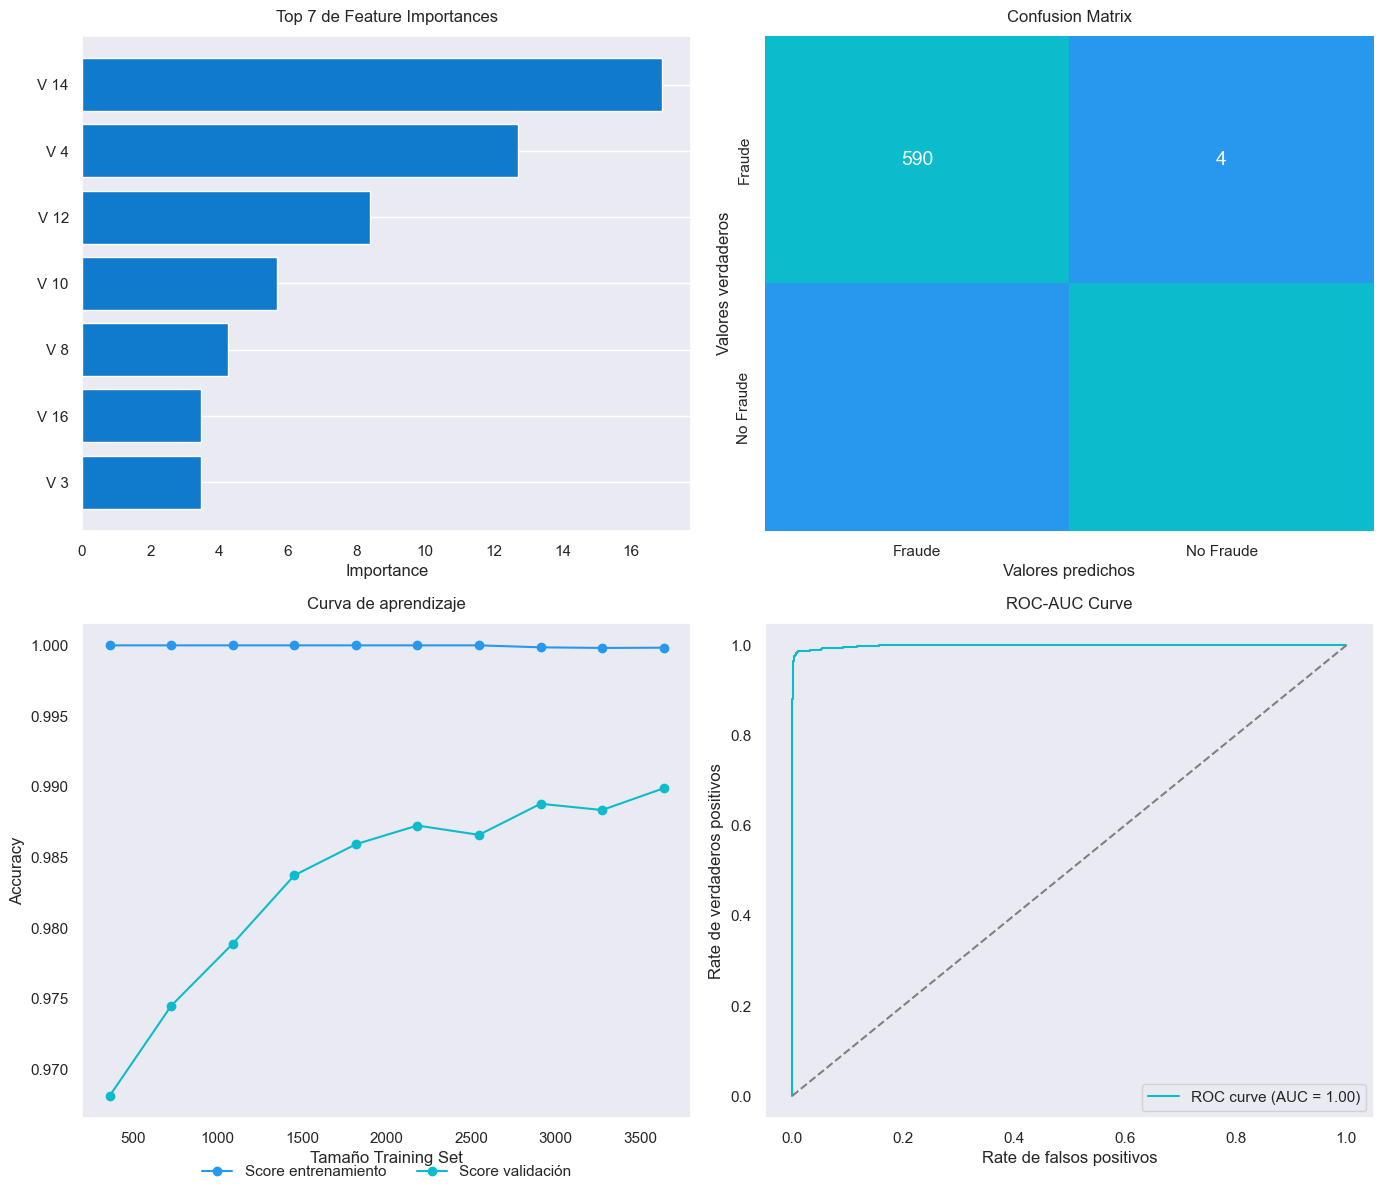

In [165]:
#Cat boosting es un algoritmo de gradient boosting, lo que permite es optimizar datos categóricos manjeandolos sin preprocesamiento

cat = CatBoostClassifier(random_state=42, verbose=0, iterations=200)
evaluate_and_visualize(cat, X_train_scaled, X_test_scaled, y_train, y_test)


Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 100.0%
	>> Test Accuracy: 98.77%


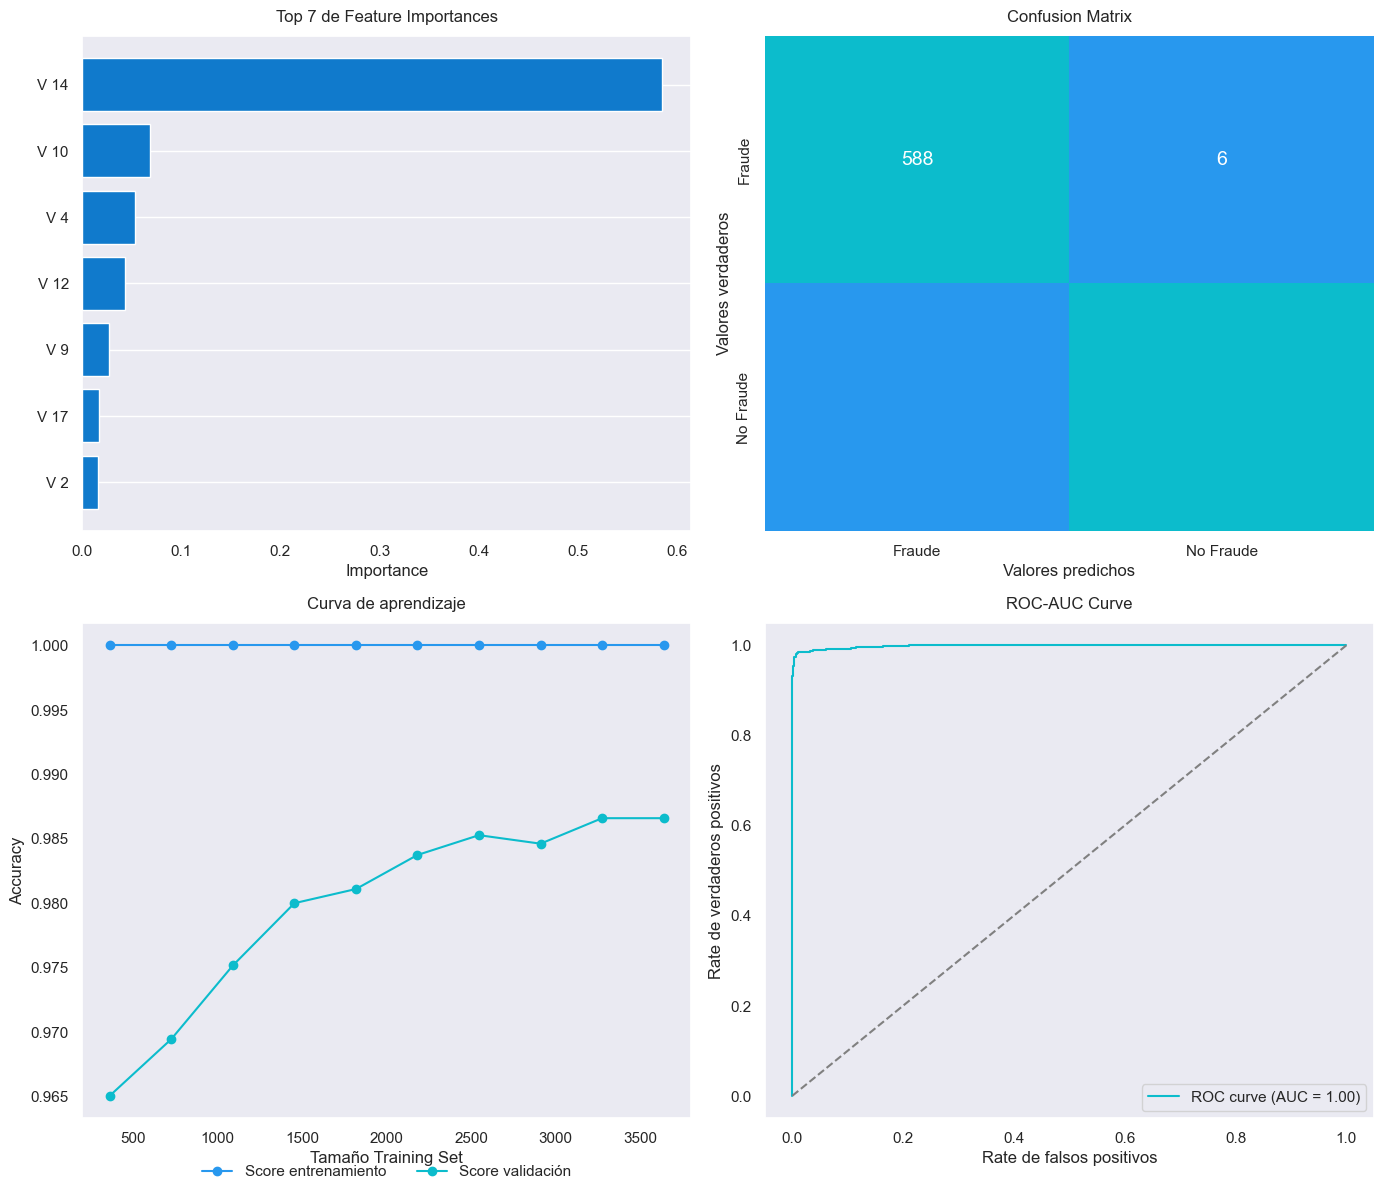

In [166]:
#XG Boost es una librería escalable de gradient boosting para alto rendimiento en implementaciones con Decision trees o árboles de decisión

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
evaluate_and_visualize(xgb, X_train_scaled, X_test_scaled, y_train, y_test)



Score de accuracy de entrenamiento y test:
	>> Entrenamiento Accuracy: 100.0%
	>> Test Accuracy: 98.946%


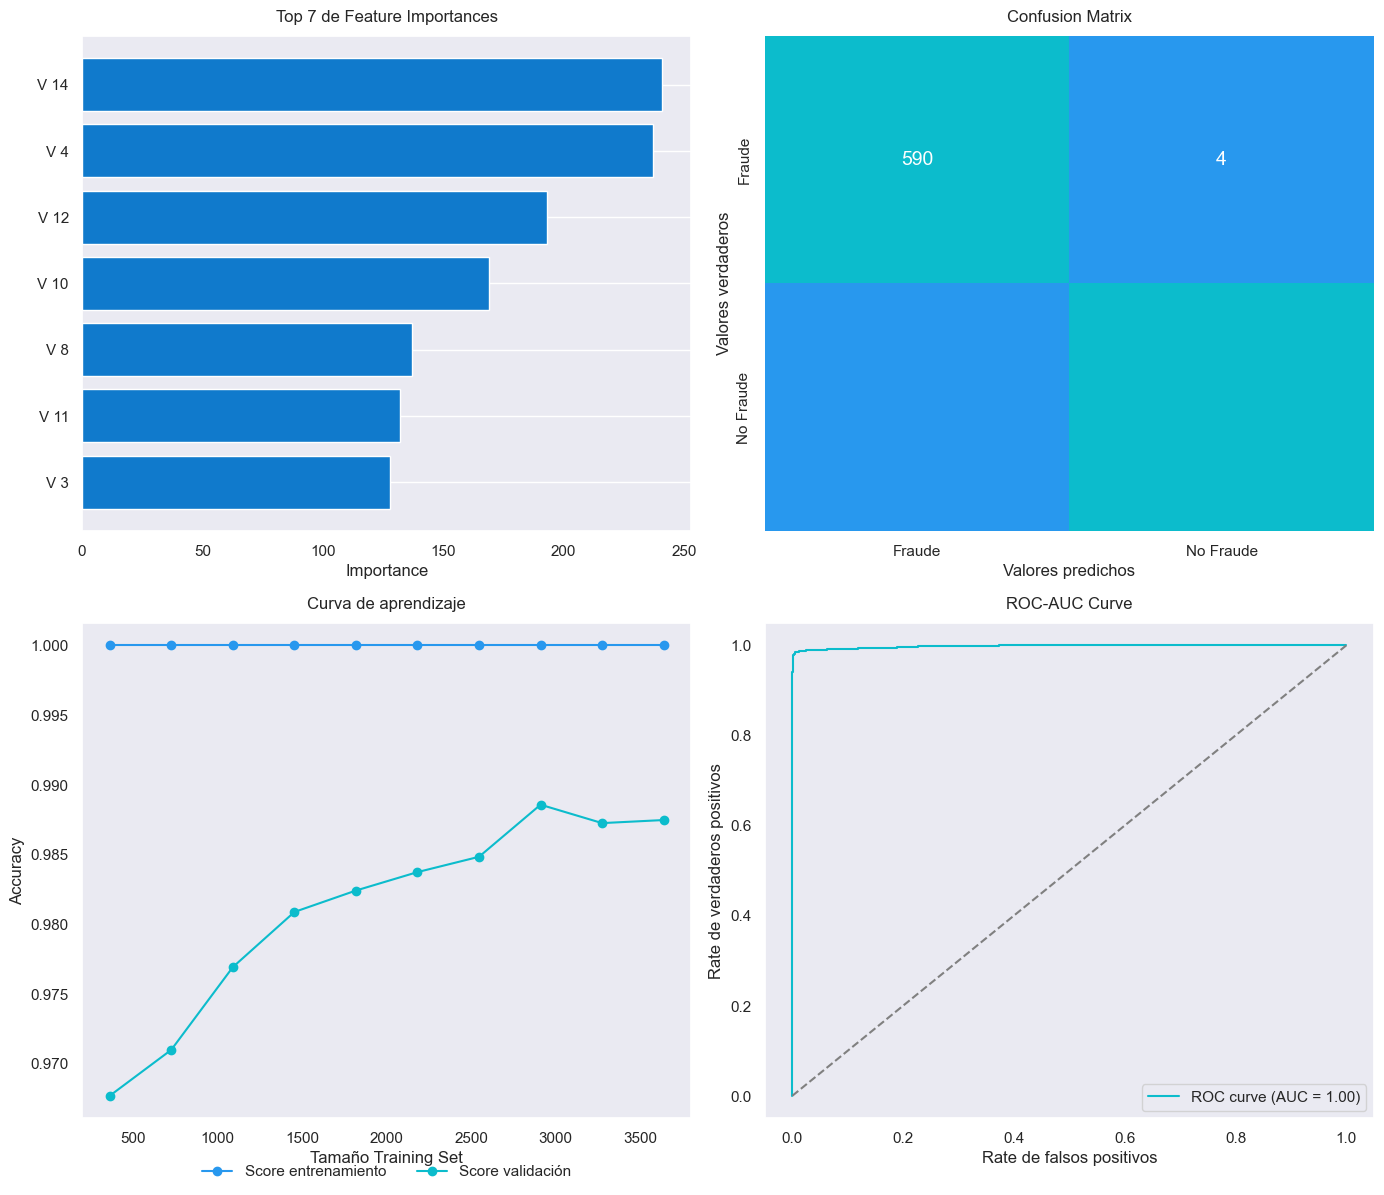

In [167]:
#Light GMB es un framework para gradient boosting que utiliza algoritmos de aprendizaje basados en árboles de decisión de manera optimizada para velocidad y eficiencia en datasets grandes

lgbm = LGBMClassifier(random_state=42,verbose=-1)
evaluate_and_visualize(lgbm, X_train_scaled, X_test_scaled, y_train, y_test)

<h1>Evaluación del Modelo</h1>

In [168]:
#Para evaluar la performance de los modelos entrenados utilizaremos métricas como Precisión, Recall, F1-Score o RMSE
metrics_df_sorted = pd.DataFrame(model_metrics)
metrics_df_sorted=metrics_df_sorted.sort_values('Accuracy',ascending=False)

metrics_df_sorted

,Model,Precision,Recall,F1-Score,Accuracy
2,ExtraTreesClassifier,0.992162,0.992091,0.992089,0.992091
7,LGBMClassifier,0.989476,0.989455,0.989453,0.989455
5,CatBoostClassifier,0.987746,0.987698,0.987695,0.987698
6,XGBClassifier,0.987702,0.987698,0.987697,0.987698
1,RandomForestClassifier,0.985127,0.985062,0.985057,0.985062
4,GradientBoostingClassifier,0.979818,0.979789,0.979785,0.979789
0,LogisticRegression,0.976500,0.976274,0.976259,0.976274
3,AdaBoostClassifier,0.967510,0.967487,0.967480,0.967487


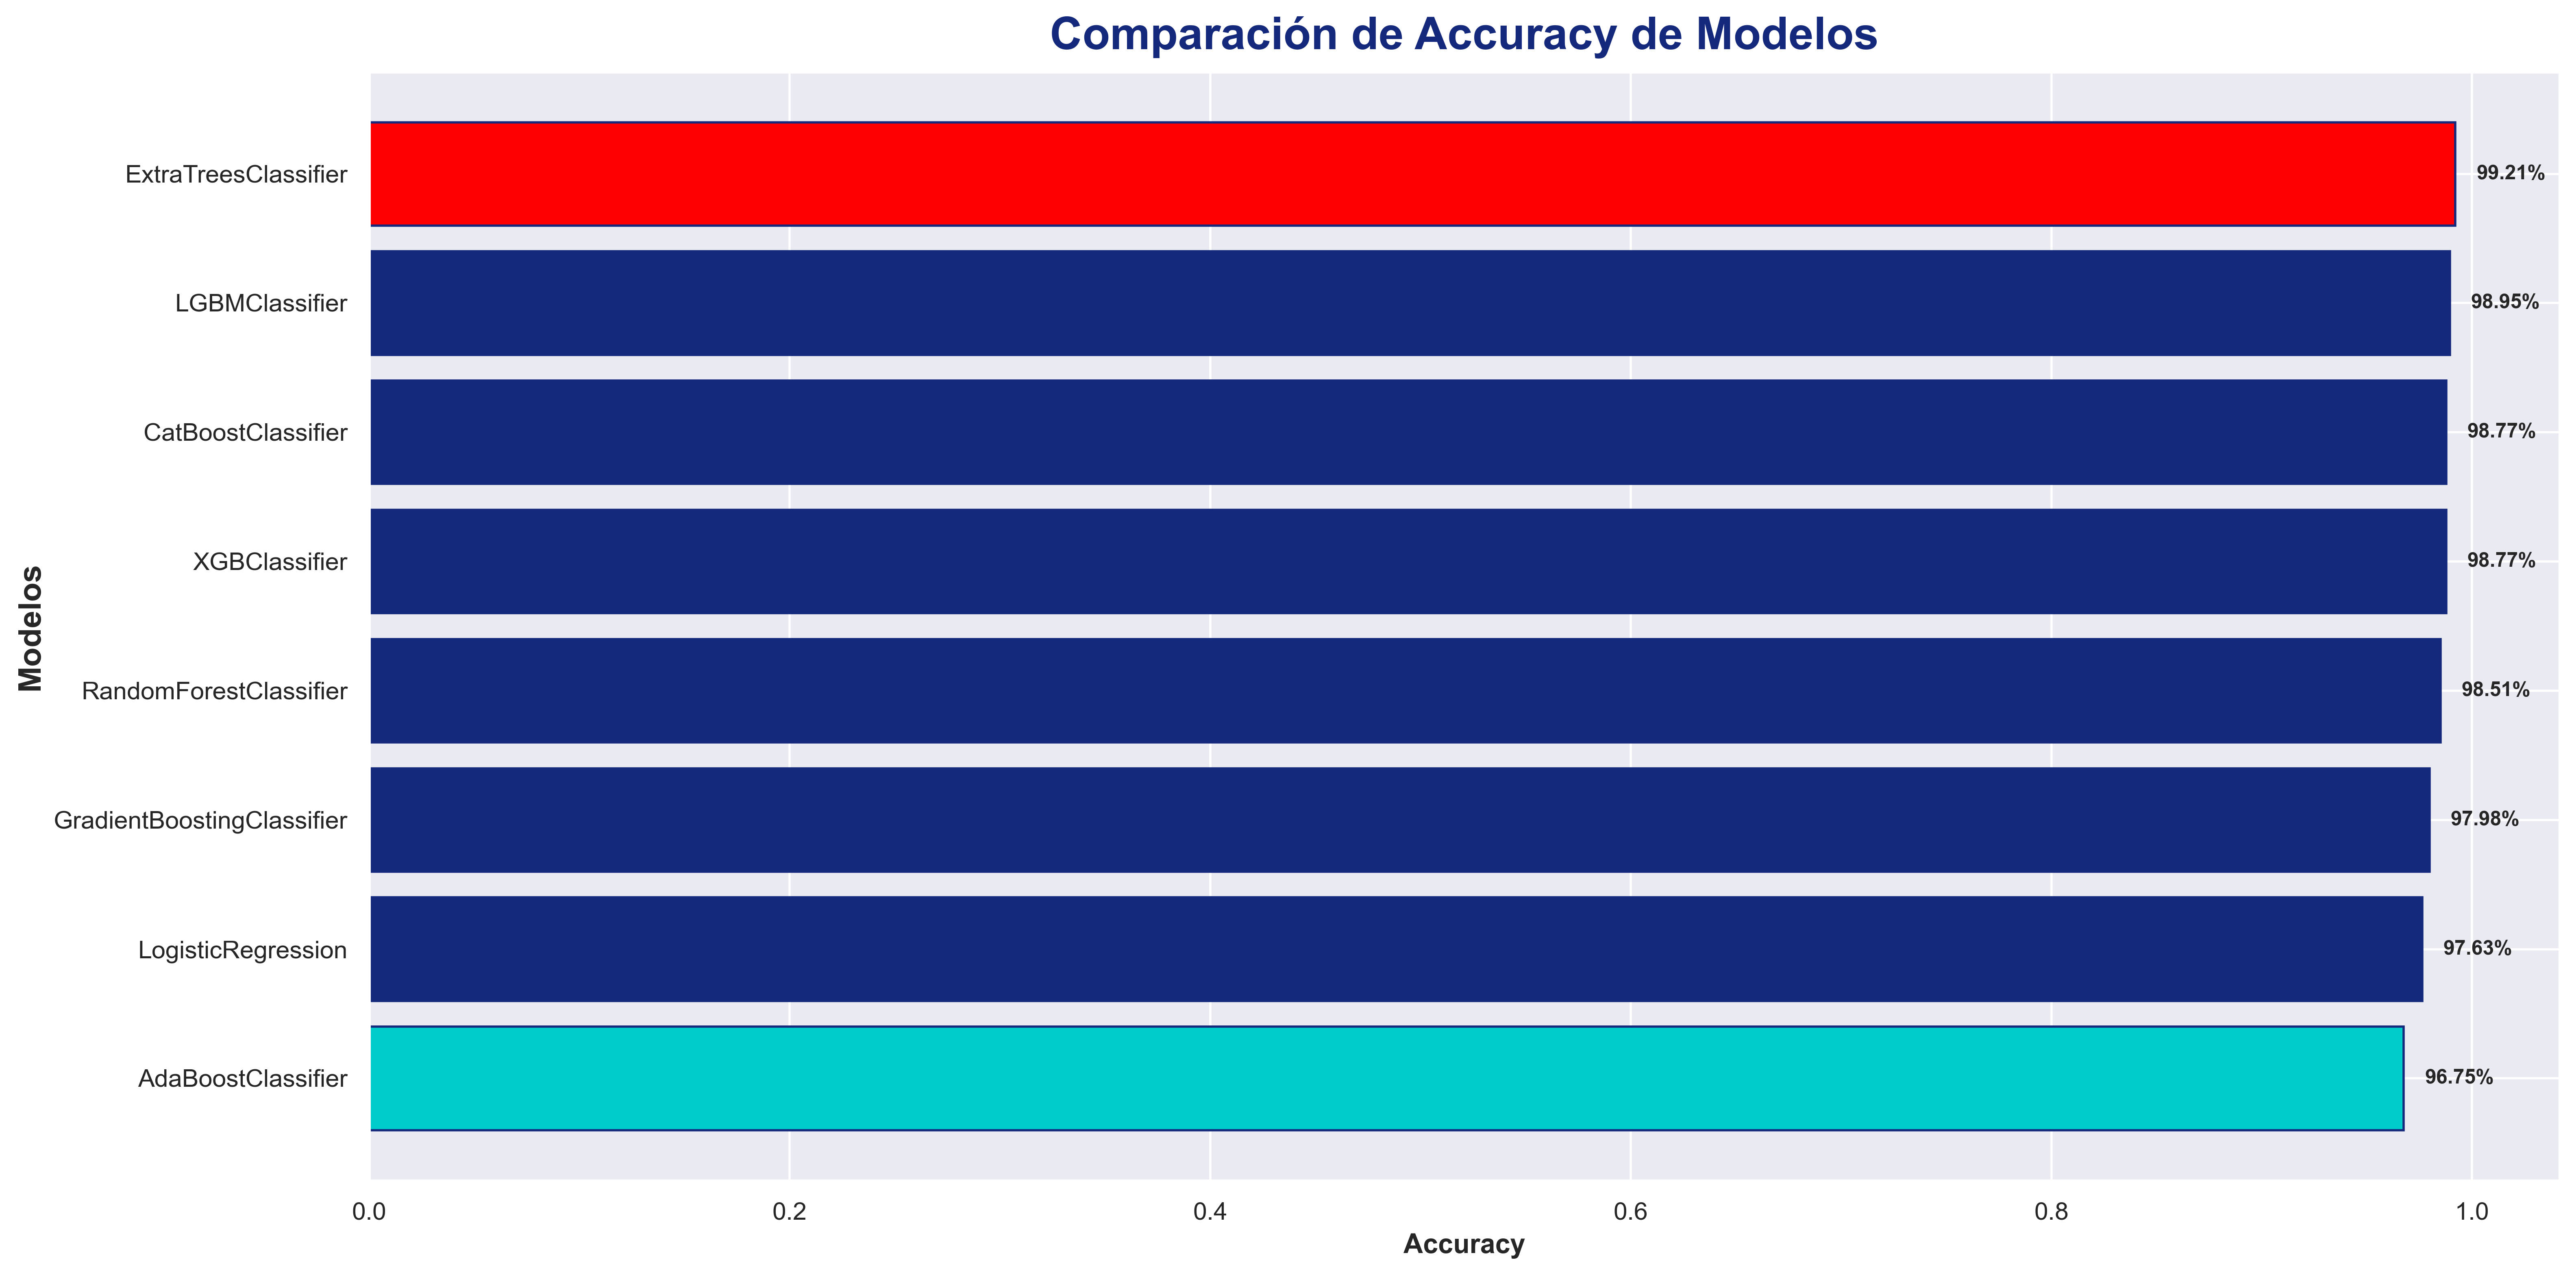

In [169]:
models = metrics_df_sorted["Model"]
accuracy = metrics_df_sorted["Accuracy"]


colors = ["#15297c"] * len(models)  #azul 
colors[0] = "#FF0000"  #rojo
colors[-1] = "#00CCCC"  #verde agua


plt.figure(figsize=(16, 8), dpi=400)
plt.barh(models, accuracy, color=colors, edgecolor="#15297c")

plt.xlabel("Accuracy", fontsize=12, weight="bold")
plt.ylabel("Modelos", fontsize=14, weight="bold")
plt.title("Comparación de Accuracy de Modelos", fontsize=20, weight="bold", color="#15297c", pad=10)


plt.gca().invert_yaxis()


for i, value in enumerate(accuracy):
    plt.text(value + 0.01, i, f"{value:.2%}", va="center", fontsize=9, weight="bold")

plt.tight_layout()
plt.show()

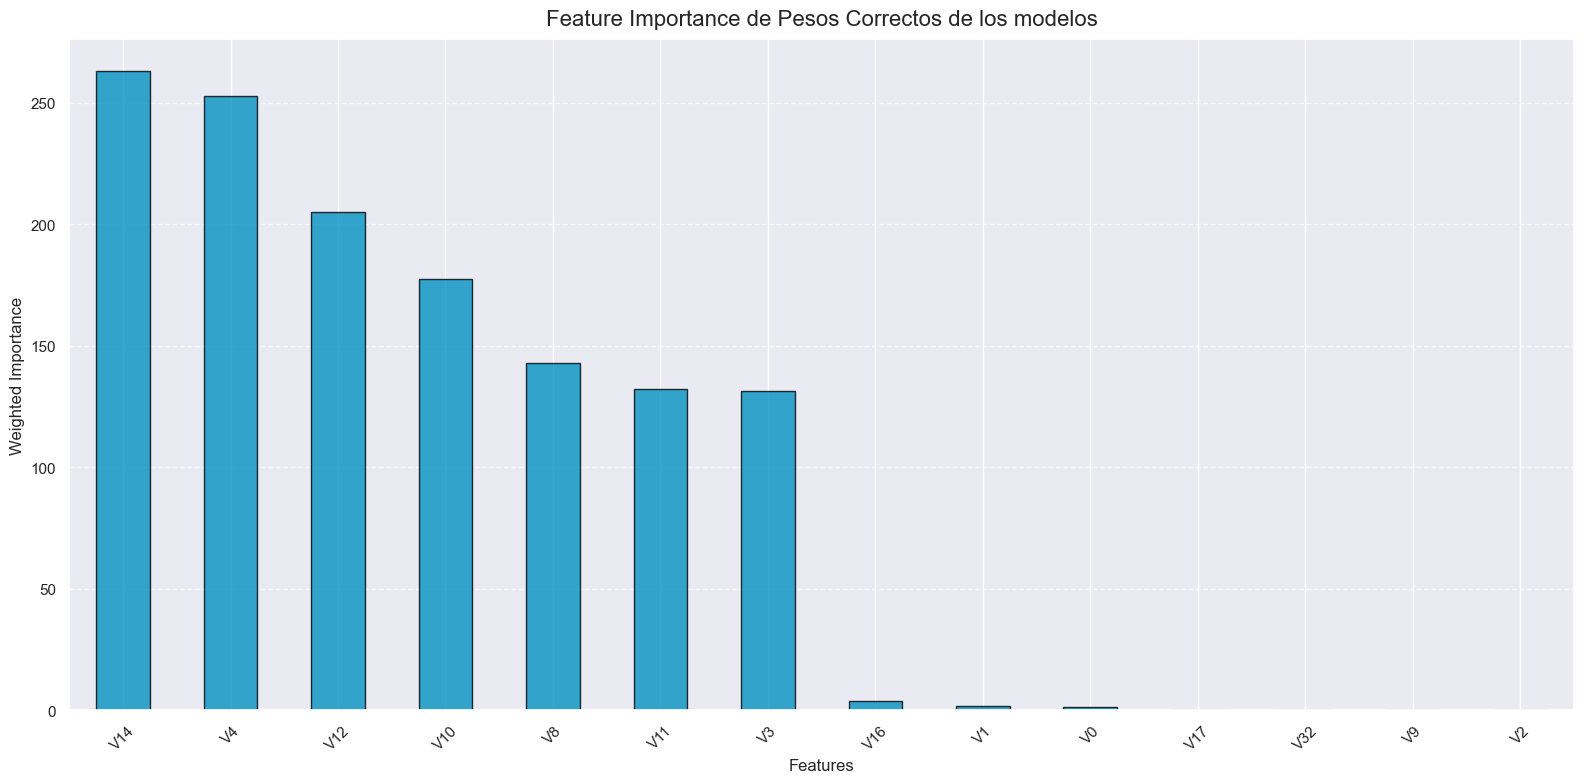

In [170]:
#Procedemos a la comparación de pesos de las variables
rows = []
for entry in feature_importance_list:
    model = entry['Model']
    for feature, importance in entry['Feature Importances'].items():
        rows.append({'Model': model, 'Feature': feature, 'Importance': importance})

df_features = pd.DataFrame(rows)

# Recalculamos la media ponderada utilizando ModelCount
weighted_importances_corrected = (
    df_features.groupby('Feature')
    .agg(ImportanceSum=('Importance', 'sum'), ModelCount=('Feature', 'count'))
)
weighted_importances_corrected['WeightedImportance'] = (
    weighted_importances_corrected['ImportanceSum'] / weighted_importances_corrected['ModelCount']
)


weighted_importances_corrected['WeightedImportance'] *= weighted_importances_corrected['ModelCount']

# Organizar por nivel de ponderación 
weighted_importances_corrected = weighted_importances_corrected.sort_values(by='WeightedImportance', ascending=False)


plt.figure(figsize=(16, 8))
weighted_importances_corrected['WeightedImportance'].plot(kind='bar', color='#0492c2', alpha=0.8, edgecolor='black')
plt.title('Feature Importance de Pesos Correctos de los modelos', fontsize=16, pad=10)
plt.ylabel('Weighted Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El análisis de la importancia de las características en múltiples modelos de clasificación revela información clave sobre las características más impactantes para la predicción. A continuación, se presenta un resumen de los hallazgos:

Característica más significativa: V14
La característica V14 aparece consistentemente como la más importante o entre las principales en todos los modelos. Muestra una importancia particularmente alta en:

CatBoostClassifier, con valores superiores a 16 en múltiples ejecuciones.

LGBMClassifier, con una puntuación de importancia de 257.

GradientBoostingClassifier y XGBClassifier, donde también domina las métricas de importancia.

Otras características altamente significativas
Las siguientes características también se clasifican consistentemente entre las más importantes en los modelos:

V4: Una característica clave con puntuaciones altas en CatBoostClassifier, LGBMClassifier y ExtraTreesClassifier.

V12: Frecuentemente entre las tres principales características en modelos como LogisticRegression, ExtraTreesClassifier y CatBoostClassifier.

V10: Muestra una importancia estable en la mayoría de los modelos, especialmente en clasificadores basados en árboles.

Perspectivas específicas del modelo
Algunas características ganan prominencia dependiendo del modelo específico:

V11: Importante en CatBoostClassifier y LGBMClassifier, pero menos relevante en otros modelos.

V3: Relevante en RandomForestClassifier, ExtraTreesClassifier y XGBClassifier.

V8: Incluida consistentemente en modelos como AdaBoostClassifier y LGBMClassifier.

Características poco importantes
Características como V16, V1 y V0 ocasionalmente aparecen en la lista de las más importantes para modelos específicos, como GradientBoostingClassifier y CatBoostClassifier, pero en general son menos significativas en términos globales.

La importancia repetida de V14, V4 y V12 sugiere que estas características son críticas para el rendimiento del modelo y deberían priorizarse en análisis posteriores o en la ingeniería de características.